## **INTRODUCTION**
### **OBJECTIF**  
Construire un syst√®me de suggestion de tags associ√©s aux questions envoy√©es sur la plateforme StackOverFlow

Stack Overflow est l‚Äôune des plus grandes plateformes communautaires d‚Äôentraide pour les d√©veloppeurs. Chaque jour, des milliers de questions y sont pos√©es, accompagn√©es de tags qui permettent de cat√©goriser les sujets abord√©s (langages, frameworks, outils, concepts, etc.).

L‚Äôobjectif de ce projet est de concevoir un syst√®me capable de **sugg√©rer automatiquement des tags pertinents** √† partir du texte d‚Äôune question (titre et corps).  
Ce syst√®me pourra aider les utilisateurs √† mieux annoter leurs questions, am√©liorer la recherche d‚Äôinformation, et faciliter la mod√©ration.

Pour cela, nous allons suivre une d√©marche compl√®te de traitement du langage naturel (NLP) en plusieurs √©tapes :

1. **Chargement et nettoyage des donn√©es** issues d‚Äôune extraction SQL sur Stack Exchange Data Explorer
2. **Exploration du corpus** pour comprendre la structure des textes et des tags
3. **Vectorisation des textes** √† l‚Äôaide de m√©thodes comme TF-IDF ou des embeddings
4. **Encodage des tags** pour la classification multi-label
5. **Mod√©lisation supervis√©e et non supervis√©e** pour pr√©dire ou regrouper les questions
6. **√âvaluation des performances** et pr√©paration au d√©ploiement

Dans un souci de rigueur et d‚Äôefficacit√©, toutes les √©tapes sont d‚Äôabord test√©es sur un √©chantillon r√©duit de 100 questions, avant d‚Äô√™tre g√©n√©ralis√©es √† l‚Äôensemble du corpus.

Ce notebook documente l‚Äôensemble de cette d√©marche, √©tape par √©tape.



### **APPROCHE**  
Afin de garantir un d√©veloppement progressif, rapide et contr√¥l√© du pipeline NLP, nous adoptons une strat√©gie en deux temps :  
1. D'abord l'exp√©rimentation sur un √©chantillon r√©duit (`sample_df`)  
2. Puis la mise √† l‚Äô√©chelle sur l‚Äôensemble du corpus (`brut_df`)  

Le tableau ci-dessous r√©sume les √©tapes concern√©es par chaque phase :  


| √âtape                         | Sur `sample_df` ? | Sur `brut_df` ? |
|------------------------------|-------------------|-----------------|
| Nettoyage                    | ‚úÖ Oui            | ‚úÖ Ensuite       |
| EDA (section 3)              | ‚úÖ Oui            | ‚ùå Pas n√©cessaire |
| Feature engineering (section 4) | ‚úÖ Oui         | ‚úÖ Ensuite       |
| Mod√©lisation                 | ‚ùå Non            | ‚úÖ Oui           |


## **IMPORTS**

In [1]:
import os
print(f"# --- VERIFICATION DU REPERTOIRE COURANT : {os.getcwd()}")
import pandas as pd
import spacy
import re
import sys
sys.path.append("../src")  # pour que Python trouve le dossier src/
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import text_cleaning
from tqdm.notebook import tqdm
from utils.tech_terms import load_tech_terms
from eda.eda_analysis import plot_distribution
from collections import Counter
from scipy.stats import entropy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
print(load_tech_terms())

from api.client.embedding_client import get_embedding
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import ast

# --- VERIFICATION DU REPERTOIRE COURANT : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks
{'c#', 'mvc 3', 'node.js', 'pandas', 'asp.net', 'tensorflow', 'react.js', 'scikit-learn', 'c++'}


## **1. RECUPERATION DES DONNEES**
**√âtapes de r√©cup√©ration √† suivre :**
- [x] Charger au format fichier csv les donn√©es retourn√©e par une requ√™te T-SQL sur Stack Exchange Data Explorer  
- [x] Charger les donn√©es dans un dataframe  

### **1.1. EXTRACTION DES DONNEES VIA STACK EXCHANGE DATA EXPLORER**
La requ√™te T-SQL saisie dans l'interface de SEDE est structur√©e de la fa√ßon suivante :

```sql
WITH Questions AS (
    SELECT
        p.Id AS PostId,
        p.Title,
        p.Body,
        p.Score,
        p.ViewCount,
        p.AnswerCount,
        p.CreationDate
    FROM Posts p
    WHERE p.PostTypeId = 1
      AND p.Score > 2
      AND p.ViewCount > 1000
      AND p.AnswerCount > 0
      AND p.Body IS NOT NULL
    ORDER BY p.Score DESC
    OFFSET 0 ROWS FETCH NEXT 500000 ROWS ONLY
),
TagsPerPost AS (
    SELECT
        pt.PostId,
        STRING_AGG(t.TagName, ';') AS Tags,
        COUNT(*) AS TagCount
    FROM PostTags pt
    JOIN Tags t ON pt.TagId = t.Id
    GROUP BY pt.PostId
)
SELECT
    q.PostId,
    q.Title,
    q.Body,
    q.Score,
    q.ViewCount,
    q.AnswerCount,
    q.CreationDate,
    t.TagCount,
    t.Tags
FROM Questions q
JOIN TagsPerPost t ON q.PostId = t.PostId
WHERE t.TagCount >= 5



| Crit√®re                | Inclus ? | Commentaire                               |
|------------------------|----------|-------------------------------------------|
| Les plus vues          | ‚úÖ        | `ViewCount > 1000`                         |
| Jug√©es pertinentes     | ‚úÖ        | `Score > 2`                                |
| Mises en favori        | ‚ùå        | Pas inclus, mais compens√© par le score     |
| Ayant re√ßu une r√©ponse | ‚úÖ        | `AnswerCount > 0`                          |
| ‚â• 5 tags               | ‚úÖ        | `TagCount >= 5`                            |
| 50 000 lignes          | ‚úÖ        | `TOP 50000` + export r√©ussi                |


**Le score d‚Äôune question Stack Overflow**  

Le **Score** d‚Äôune question = nombre de votes positifs ‚Äì votes n√©gatifs  
Il refl√®te la **pertinence per√ßue par la communaut√©**.

Voici comment interpr√©ter les scores :

- `0` ‚Üí question ignor√©e ou neutre  
- `1‚Äì2` ‚Üí question correcte mais peu visible  
- `3‚Äì10` ‚Üí question utile  
- `10+` ‚Üí question tr√®s appr√©ci√©e  
- `100+` ‚Üí question culte


### **1.2. CHARGEMENT DES DONNEES DANS UN DATAFRAME**

In [2]:
# ---------------------------
# --- CHARGER LE FICHIER CSV
# ---------------------------
brut_df = pd.read_csv("../data/raw/stackoverflow_questions_sede.csv")
# -----------------------------------------------
# --- VERIFIER LE NOMBRE DE LIGNES ET UN APERCU
# -----------------------------------------------
print(f"Nombre de questions : {len(brut_df)}")
brut_df.head()

Nombre de questions : 50000


PostId                                              Title  \
0      19     What is the fastest way to get the value of œÄ?   
1     594     cx_Oracle: How do I iterate over a result set?   
2     696                      Connect PHP to IBM i (AS/400)   
3     855            .Net XML comment into API Documentation   
4    1898  Import CSV file to strongly typed data structu...   

                                                Body  Score  ViewCount  \
0  <p>I'm looking for the fastest way to obtain t...    356      73332   
1  <p>There are several ways to iterate over a re...     55      61757   
2  <p>I've got an upcoming project wherein I will...     37       9502   
3  <p>Is there an easy way to produce MSDN-style ...     21       3526   
4  <p>What's the best way to import a CSV file in...    108      71126   

   AnswerCount         CreationDate  TagCount  \
0           23  2008-08-01 05:21:22         5   
1            3  2008-08-03 01:15:08         5   
2            9  2008-08-03 14:03:28         5   
3            6  2008-08-03 22:03:37         5   
4           11  2008-08-05 04:43:22         5   

                                                Tags  
0    language-agnostic;unix;algorithm;performance;pi  
1      python;sql;database;cx-oracle;oracle-database  
2                 php;database;db2;odbc;ibm-midrange  
3  documentation;xslt;sandcastle;xml-comments;vis...  
4                          c#;vb.net;csv;import;file

## **2. NETTOYAGE DES DONNEES**

**Objectif : transformer du texte brut en texte propre et exploitable**

**Les √©tapes de nettoyage √† appliquer :**  

1. Suppression des balises HTML

2. Passage en minuscules

3. Suppression de la ponctuation, des chiffres, des caract√®res sp√©ciaux

4. Tokenisation

5. Lemmatisation

6. Suppression des stopwords

7. Cr√©ation de colonnes clean_title, clean_body

***Pourquoi travailler d'abord sur un √©chantillon de 100 questions ?***

Avant d'appliquer un pipeline NLP complet sur un jeu de donn√©es massif (ici 50 000 questions Stack Overflow),  
> **Il est judicieux de travailler d'abord sur un petit √©chantillon (ex : 100 questions).** 

Cette approche pr√©sente ces avantages :

| Avantage | Pourquoi c‚Äôest utile |
|----------|----------------------|
| üí® Rapidit√© | Permet de tester et corriger rapidement sans attendre de longs temps de traitement |
| üß™ D√©bogage facile | Facilite l'observation des erreurs ou effets inattendus dans les fonctions de nettoyage |
| üìä Visualisation claire | Les graphiques et tableaux sont plus lisibles sur un petit corpus |
| üß± Modularit√© | Permet de construire des fonctions r√©utilisables et test√©es |
| üß† Compr√©hension | Aide √† observer les effets du nettoyage, de la fr√©quence, etc. mot par mot |

Une fois que le pipeline est valid√© sur l‚Äô√©chantillon, 
> **on peut le mettre √† l‚Äô√©chelle sur l‚Äôensemble du jeu de donn√©es (`brut_df`) en appliquant les m√™mes fonctions.**


### **2.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

In [3]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES DE NETTOYAGES
# -------------------------------------------
import importlib
import preprocessing.text_cleaning as tc
importlib.reload(tc)

# --------------------------------------------------
# --- ON CONSTRUIT UN ECHANTILLON DE 100 QUESTIONS
# --------------------------------------------------
sample_df = brut_df.sample(100, random_state=42).copy()
# ----------------------------------------
# --- NETTOYAGE DES CORPUS TITLE ET BODY
# ----------------------------------------
sample_clean = sample_df.copy()
tqdm.pandas()
sample_clean["clean_title"] = sample_clean["Title"].progress_apply(tc.clean_text_spacy_custom)
sample_clean["clean_body"] = sample_clean["Body"].progress_apply(tc.clean_text_spacy_custom)

# --- APERCU DU RESULTAT
sample_clean[["Title", "clean_title", "Body", "clean_body"]].head(3)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Title  \
33553  Why are Haskell Maps implemented as balanced b...   
9427   Measuring the average thickness of traces in a...   
199    How to create a dynamic LINQ join extension me...   

                                             clean_title  \
33553  haskell maps implement balanced binary tree in...   
9427               measure average thickness trace image   
199            create dynamic linq join extension method   

                                                    Body  \
33553  <p>From my limited knowledge of Haskell, it se...   
9427   <p>Here's the problem: I have a number of bina...   
199    <p>There was a library of dynamic <a href="htt...   

                                              clean_body  
33553  limited knowledge haskell maps data map suppos...  
9427   problem number binary image compose trace diff...  
199    library dynamic linq extension method release ...

## **3. EXPLORATION**

**Objectif : comprendre la structure du texte et du vocabulaire**  

L‚Äôobjectif de cette section est d‚Äôexplorer le contenu textuel des questions Stack Overflow afin de mieux comprendre la structure du corpus, la richesse du vocabulaire, la distribution des tags et les √©ventuelles anomalies.  
Cette phase exploratoire est essentielle pour guider les choix de nettoyage, de vectorisation et de mod√©lisation.  
Toutes les analyses sont men√©es sur un √©chantillon r√©duit de 100 questions (`sample_df`) afin de faciliter l‚Äôexp√©rimentation et la visualisation.




**Les √©tapes d'exploration √† appliquer :**  
1. Fr√©quences de mots  
2. Nuages de mots  
3. Longueur des documents  
4. Distribution des tags  
5. Co-occurrence de mots ou de tags

### **3.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

***--- PR√âPARATION DE LA PHASE D‚ÄôEXPLORATION***  
On part du DataFrame nettoy√© obtenu √† l‚Äôissue de la phase de pr√©traitement.  
Pour √©viter toute modification accidentelle, on travaille sur une copie :  
> df_explo = sample_df.copy()  

Cette copie sera utilis√©e dans toutes les √©tapes d‚Äôanalyse exploratoire :  
- visualisation des distributions  
- d√©tection des doublons et outliers  
- analyse des tags  
- etc.  

#### **3.1.1. FREQUENCE DES MOTS**

word  frequency
0      create          7
1       class          6
2      method          4
3      object          4
4      cursor          4
..        ...        ...
95      trace          1
96       linq          1
97       join          1
98  extension          1
99  interface          1

[100 rows x 2 columns]

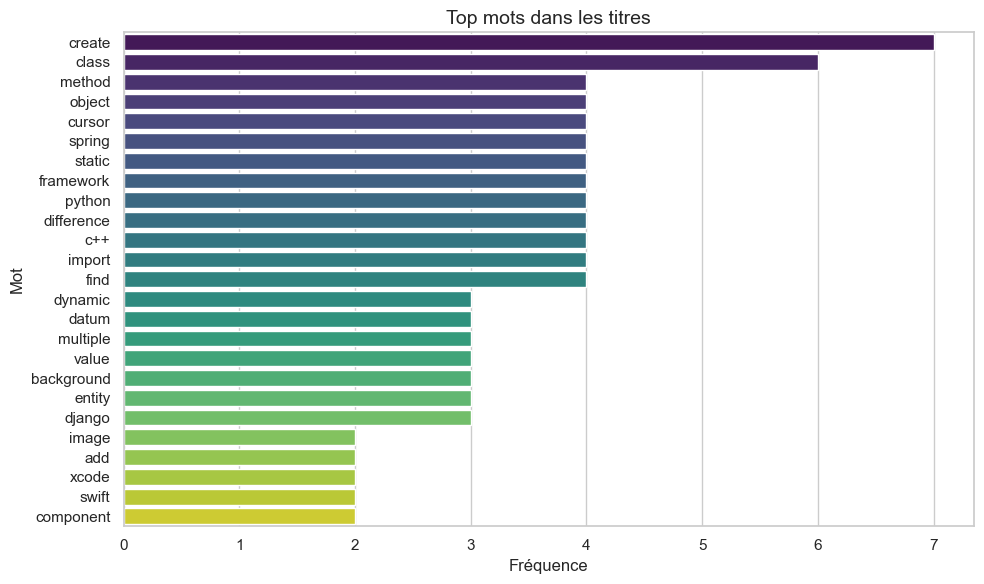

word  frequency
0         time         69
1         like         58
2        class         57
3        write         51
4         work         51
..         ...        ...
95     content         12
96         nil         12
97  completion         12
98      nsdata         12
99         hue         12

[100 rows x 2 columns]

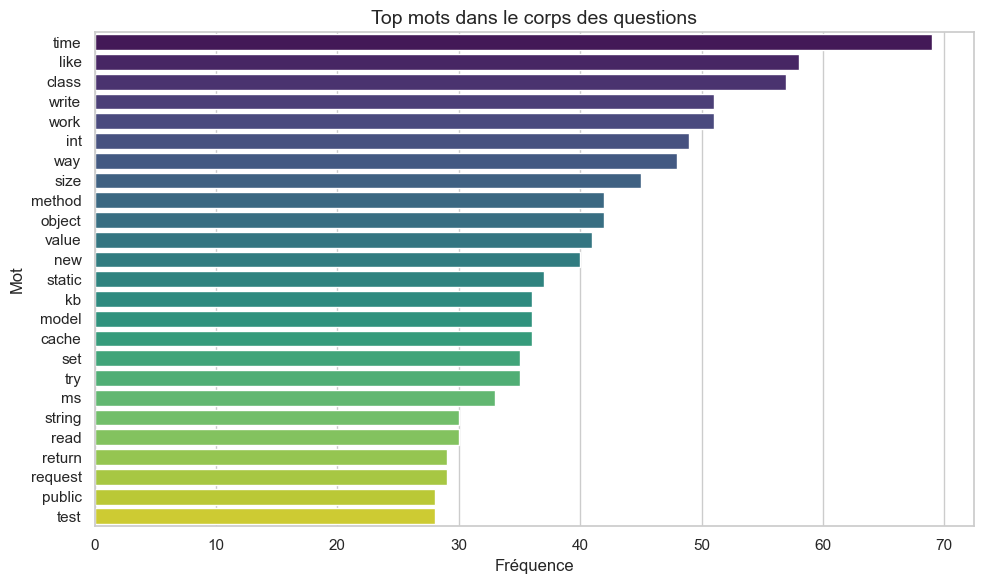

In [4]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# Copie de travail pour toute l‚Äôexploration
sample_explo = sample_clean.copy()

# -------------------------------
# --- ANALYSE FREQUENCE DES MOTS
# -------------------------------
# --- CORPUS TITLE
freq_title = eda.compute_word_frequencies(sample_explo, "clean_title", top_n=100)
display(freq_title)
eda.plot_word_frequencies(freq_title, max_words_display=25, palette="viridis", title="Top mots dans les titres")
# --- CORPUS BODY
freq_body = eda.compute_word_frequencies(sample_explo, "clean_body", top_n=100)
display(freq_body)
eda.plot_word_frequencies(freq_body, max_words_display=25, palette="viridis", title="Top mots dans le corps des questions")


#### **3.1.2. NUAGE DE MOTS**

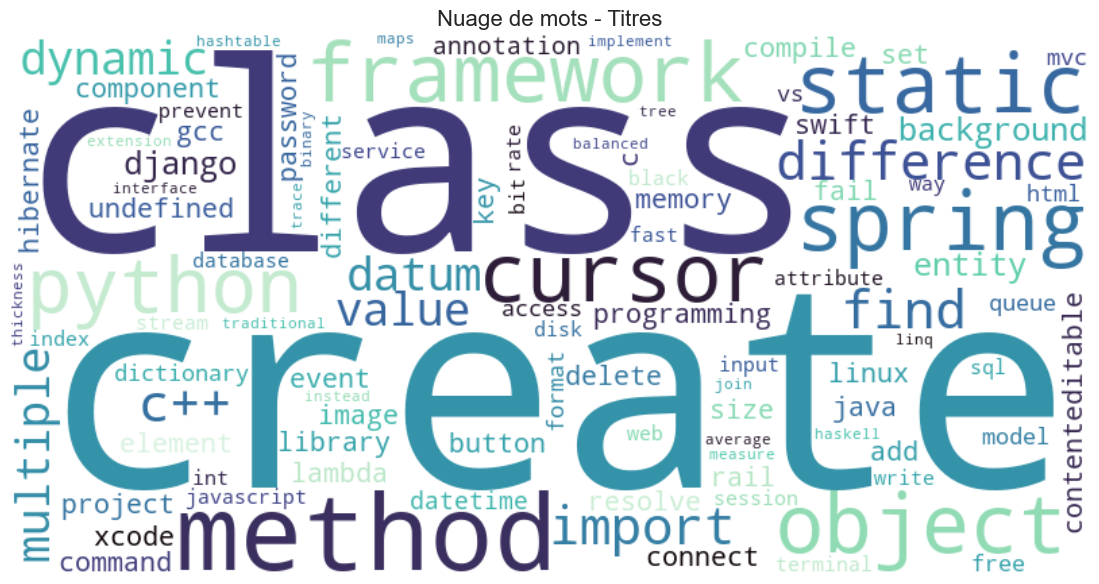

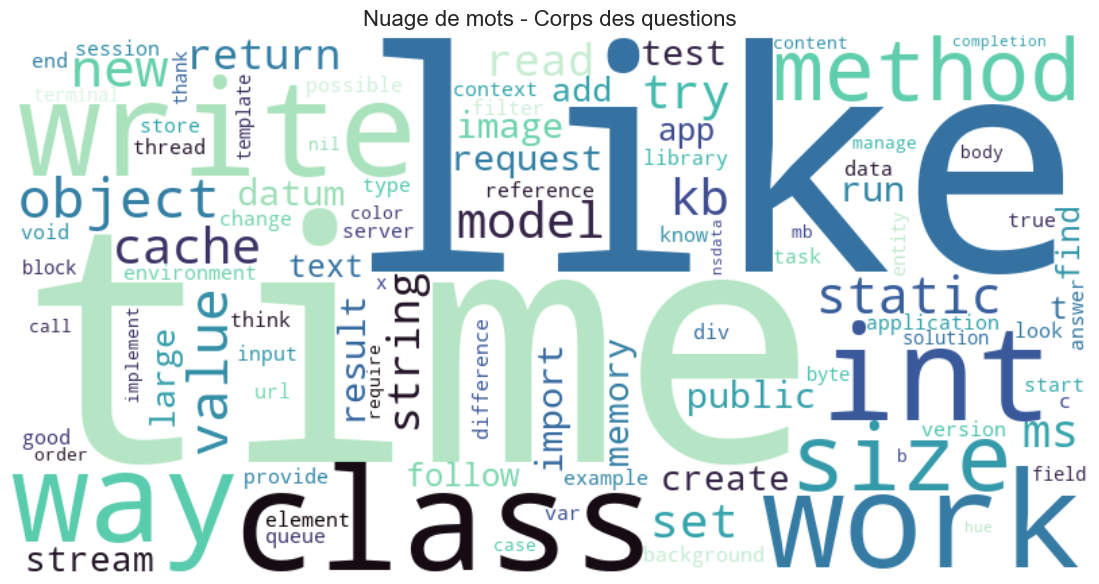

In [5]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)
# -------------------
# --- NUAGE DE MOTS
# -------------------
# --- NUAGE POUR TITLE
eda.generate_wordcloud(freq_title, max_words=100, colormap="mako", title="Nuage de mots - Titres")
# --- NUAGE POUR BODY
eda.generate_wordcloud(freq_body, max_words=100, colormap="mako", title="Nuage de mots - Corps des questions")

#### **3.1.3. ANALYSE DE LA LONGUEUR DES DOCUMENTS ET DE LA FORME DE SA DISTRIBUTION**

Dans cette sous-section, nous analysons la longueur des titres et des corps de questions, √† la fois en nombre de caract√®res et en nombre de mots.  
L‚Äôobjectif est de mieux comprendre la structure du corpus, d‚Äôidentifier d‚Äô√©ventuelles anomalies (questions trop courtes ou trop longues), et de poser les bases pour d‚Äô√©ventuels filtres ou ajustements dans les √©tapes suivantes.  
Cette analyse est men√©e sur l‚Äô√©chantillon `sample_df`.  

1. Longueur en caract√®res et en mots (titres et corps, bruts et nettoy√©s)  
***Interpr√©tation***  
> Un ratio proche de 1 ‚Üí peu de nettoyage (texte d√©j√† concis)  
> Un ratio proche de 0.5 ‚Üí environ la moiti√© des mots ont √©t√© supprim√©s (stopwords, ponctuation, etc.)  
> Un ratio tr√®s bas (< 0.2) ‚Üí texte tr√®s verbeux ou bruit√© √† l‚Äôorigine

2. Histogrammes  
3. D√©tection des outliers

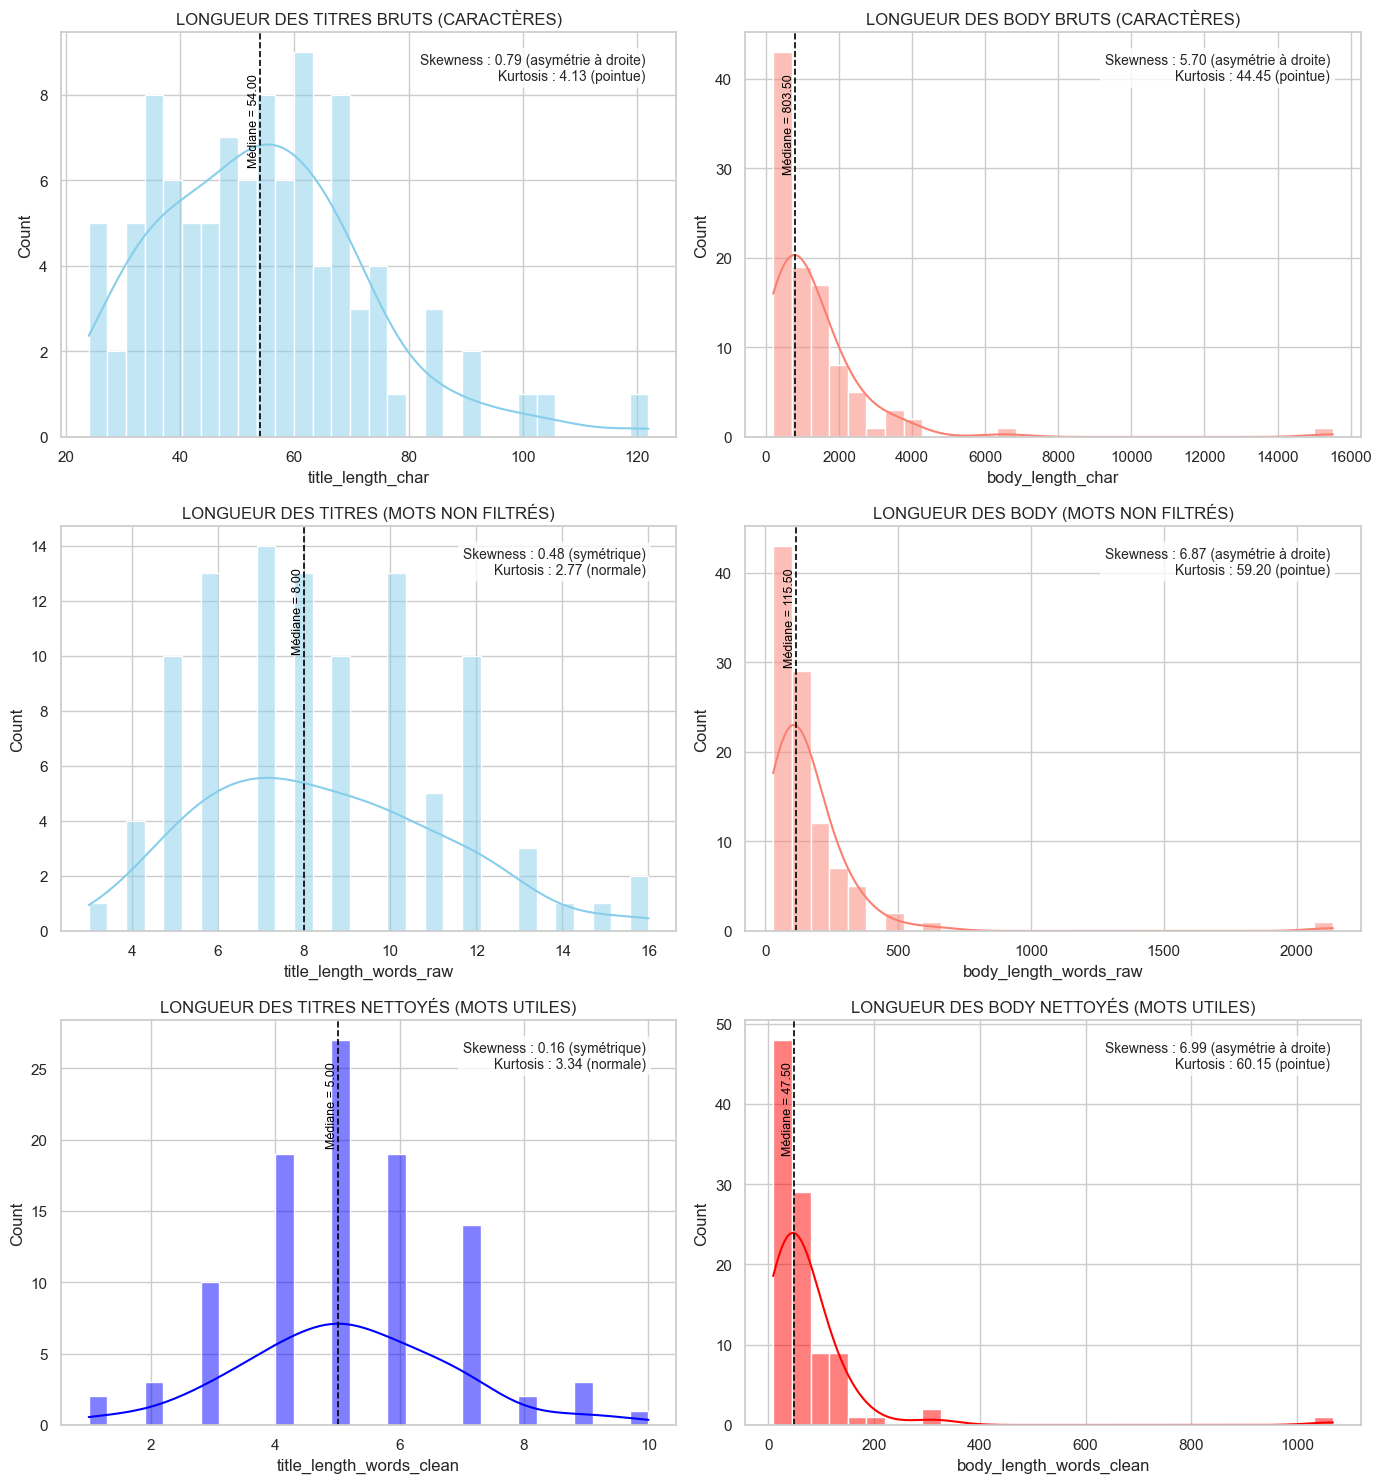

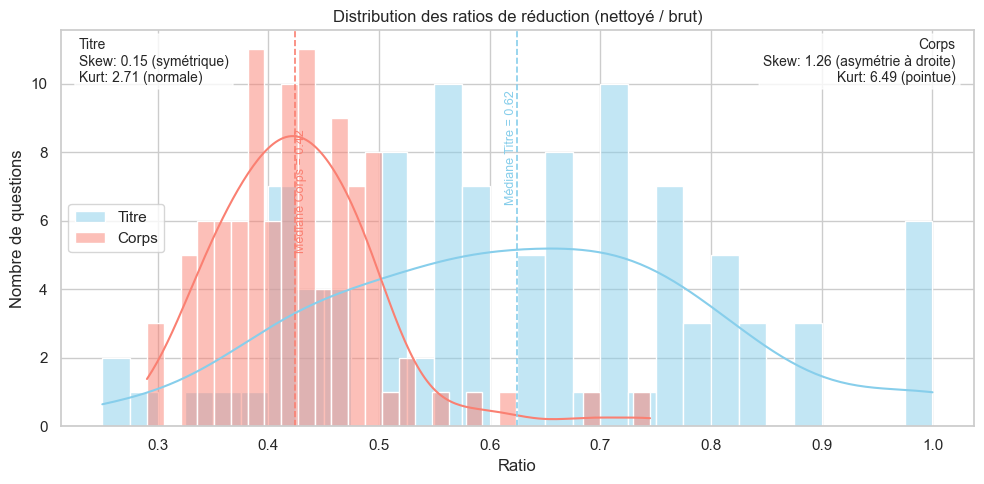

In [6]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)
# ----------------------------------------------------------------------------------
# --- ON MESURE LA LONGUEUR EN CARACTERES DE CHAQUE DOCUMENT DE CHAQUE CORPUS BRUTES
# ----------------------------------------------------------------------------------
# --- CORPUS TITLE
sample_explo["title_length_char"] = sample_explo["Title"].str.len()
# --- CORPUS BODY
sample_explo["body_length_char"] = sample_explo["Body"].str.len()

# ----------------------------------------------------------------------------------
# --- ON MESURE LA LONGUEUR EN NOMBRE DE MOTS DE CHAQUE DOCUMENT DE CHAQUE CORPUS BRUTES
# ----------------------------------------------------------------------------------
# --- CORPUS TITLE
sample_explo["title_length_words_raw"] = sample_explo["Title"].str.split().apply(len)
# --- CORPUS BODY
sample_explo["body_length_words_raw"] = sample_explo["Body"].str.split().apply(len)

# -----------------------------------------------------------------------------------
# --- ON MESURE LA LONGUEUR EN NOMBRE DE MOTS DE CHAQUE DOCUMENT DE CHAQUE CORPUS NETTOYE
# -----------------------------------------------------------------------------------
# --- CORPUS TITLE NETTOYE
sample_explo["title_length_words_clean"] = sample_explo["clean_title"].str.split().apply(len)
# --- CORPUS BODY NETTOYE
sample_explo["body_length_words_clean"] = sample_explo["clean_body"].str.split().apply(len)

# ------------------------------------
# --- VISUALIUSATION DES DISTRIBUTIONS
# -------------------------------------
# --- LISTE DES DISTRIBUTIONS A TRACER
plots = [
    ("title_length_char", "LONGUEUR DES TITRES BRUTS (CARACT√àRES)", "skyblue"),
    ("body_length_char", "LONGUEUR DES BODY BRUTS (CARACT√àRES)", "salmon"),
    ("title_length_words_raw", "LONGUEUR DES TITRES (MOTS NON FILTR√âS)", "skyblue"),
    ("body_length_words_raw", "LONGUEUR DES BODY (MOTS NON FILTR√âS)", "salmon"),
    ("title_length_words_clean", "LONGUEUR DES TITRES NETTOY√âS (MOTS UTILES)", "blue"),
    ("body_length_words_clean", "LONGUEUR DES BODY NETTOY√âS (MOTS UTILES)", "red"),
]

# --- CREATION DE LA GRILLE D'AFFICHAGE 3x2
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# --- BOUCLE SUR LES CONFIGURATIONS
for i, (col, title, color) in enumerate(plots):
    row, col_idx = divmod(i, 2)
    eda.plot_distribution(axes[row, col_idx], sample_explo[col], title, color)

plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# --- STATISTIQUES DESCRIPTIVES DE LA LONGUEUR DES CORPUS NETTOYES
# -----------------------------------------------------------------
sample_explo[[
    "title_length_char", "body_length_char",
    "title_length_words_raw", "body_length_words_raw",
    "title_length_words_clean", "body_length_words_clean",
]].describe()

# -------------------------------------------------------
# --- REDUCTION MOYENNE DU NOMBRE DE MOTS APRES NETTOYAGE
# -------------------------------------------------------
# --- PROPORTION DE MOTS CONSERVES DANS LE TITRE APRES NETTOYAGE
sample_explo["title_reduction_ratio"] = sample_explo["title_length_words_clean"] / sample_explo["title_length_words_raw"]
# --- PROPORTION DE MOTS CONSERVES DANS LE BODY APRES NETTOYAGE
sample_explo["body_reduction_ratio"] = sample_explo["body_length_words_clean"] / sample_explo["body_length_words_raw"]

# ------------------------------------------------------
# --- STATISTIQUES DESCRIPTIVES DU RATIO DE MOTS UTILES
# ------------------------------------------------------
sample_explo[["title_reduction_ratio", "body_reduction_ratio"]].describe()

# -------------------------------------
# --- VISUALISATION DES DISTRIBUTIONS
# -------------------------------------
# --- ON VISUALISE LE RATIO DE MOTS UTILES POUR LE CORPUS TITLE NETTOYE ET LE CORPUS BODY NETTOYE
eda.plot_dual_distribution(
    data1=sample_explo["title_reduction_ratio"],
    data2=sample_explo["body_reduction_ratio"],
    label1="Titre",
    label2="Corps",
    title="Distribution des ratios de r√©duction (nettoy√© / brut)",
    xlabel="Ratio"
)

***INTERPRETATION***  
Les distributions montrent que :
- Les titres sont g√©n√©ralement courts (souvent entre 5 et 15 mots)
- Les corps de questions sont plus variables, avec des pics autour de 50 √† 150 mots
- Quelques outliers tr√®s longs ou tr√®s courts sont pr√©sents

Ces observations permettront de fixer des seuils pour filtrer les questions aberrantes dans la suite du pipeline.

#### **3.1.4. DETECTION DES OUTLIERS ET DOUBLONS**
Avant de passer √† la vectorisation, il est important de d√©tecter les cas aberrants dans le corpus.  
Dans cette sous-section, nous identifions les titres ou corps vides, les questions anormalement courtes ou longues, ainsi que les cas o√π le nombre de tags est incoh√©rent (ex. : 0 ou plus de 5 tags).  
Ces v√©rifications permettent d‚Äôassurer la qualit√© des donn√©es en amont de la mod√©lisation.  

1. Titres ou corps vides  
2. Questions trop longues ou trop courtes  
3. Questions avec 0 ou > 5 tagsES DOUBLONS ET OUTLIERS**

##### ***3.1.4.1. D√âTECTION DES DOUBLONS EXACTS***

In [7]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)


# -------------------------------------
# --- D√âTECTION DES DOUBLONS EXACTS
# -------------------------------------

# Nombre total de questions
total_questions = sample_explo.shape[0]

# D√©tection des doublons exacts sur le couple (Title, Body)
duplicate_mask = sample_explo.duplicated(subset=["Title", "Body"], keep=False)
duplicates_df = sample_explo[duplicate_mask]

# Nombre de doublons
nb_duplicates = duplicates_df.shape[0]
nb_unique_duplicates = duplicates_df.duplicated(subset=["Title", "Body"]).sum()

# Affichage
print(f"Nombre total de questions : {total_questions}")
print(f"Nombre de doublons exacts (Title + Body) : {nb_duplicates}")
print(f"Nombre de doublons √† supprimer (copies identiques) : {nb_unique_duplicates}")
print(f"Proportion de doublons dans l‚Äô√©chantillon : {nb_duplicates / total_questions:.2%}")

# Afficher quelques doublons pour inspection
duplicates_df.sort_values(by="Title").head(6)[["Title", "Body"]]

# Suppression des doublons exacts (on garde la premi√®re occurrence)
sample_explo = sample_explo.drop_duplicates(subset=["Title", "Body"], keep="first").reset_index(drop=True)


Nombre total de questions : 100
Nombre de doublons exacts (Title + Body) : 0
Nombre de doublons √† supprimer (copies identiques) : 0
Proportion de doublons dans l‚Äô√©chantillon : 0.00%


Nous avons d√©tect√© X doublons exacts dans l‚Äô√©chantillon, repr√©sentant Y % du corpus. Ces doublons peuvent r√©sulter de reposts ou d‚Äôerreurs de collecte. Afin d‚Äô√©viter un biais dans les analyses de fr√©quence ou d‚Äôentra√Ænement de mod√®les, nous avons choisi de ne conserver qu‚Äôune seule occurrence de chaque doublon.

##### ***3.1.4.2. D√âTECTION DES DOUBLONS PARTIELS : M√äME TITRE, CORPS DIFF√âRENT***

On va maintenant chercher les cas o√π :  
> le titre est identique, mais le corps est diff√©rent  
Ce sont souvent des reposts, des reformulations ou des tentatives de reformuler une m√™me question.

In [8]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ------------------------------------------------------------------
# --- D√âTECTION DES DOUBLONS PARTIELS : M√äME TITRE, CORPS DIFF√âRENT
# ------------------------------------------------------------------

# Grouper par titre et compter le nombre de corps distincts associ√©s
title_groups = sample_explo.groupby("Title")["Body"].nunique()

# S√©lectionner les titres associ√©s √† plusieurs corps diff√©rents
partial_duplicates_titles = title_groups[title_groups > 1].index

# Extraire les lignes concern√©es
partial_duplicates_df = sample_explo[sample_explo["Title"].isin(partial_duplicates_titles)]

# Affichage
print(f"Nombre de titres partag√©s par plusieurs corps diff√©rents : {len(partial_duplicates_titles)}")
print(f"Nombre total de questions concern√©es : {partial_duplicates_df.shape[0]}")

# Afficher quelques exemples pour inspection
partial_duplicates_df.sort_values("Title").head(6)[["Title", "Body"]]


Nombre de titres partag√©s par plusieurs corps diff√©rents : 0
Nombre total de questions concern√©es : 0


Empty DataFrame
Columns: [Title, Body]
Index: []

***INTERPRETATION***  
Nous avons identifi√© plusieurs cas o√π un m√™me titre est associ√© √† des corps de texte diff√©rents.  
Cela peut indiquer :  
- des reformulations,  
- des reposts partiels  
- ou des titres trop g√©n√©riques. 

> Ces doublons partiels peuvent biaiser les analyses de fr√©quence ou de similarit√© s√©mantique.  
> Une strat√©gie de regroupement ou de filtrage pourrait √™tre envisag√©e.

Plusieurs options se pr√©sentent selon l'objectif :

- Les regrouper (par titre) sion veut analyser des questions similaires  
- Les filtrer si on veut un corpus plus diversifi√©  
- Les garder si on veut entra√Æner un mod√®le robuste √† la redondance

##### ***3.1.4.3. D√âTECTION DES DOUBLONS FLOUS***

In [9]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ----------------------------------------------------------
# --- D√âTECTION OPTIONNELLE DE DOUBLONS FLOUS SUR LES TITRES
# ----------------------------------------------------------

# if False:  # ‚Üê d√©sactiv√© pour l‚Äôinstant
if True:
    fuzzy_dups = eda.detect_fuzzy_duplicates(sample_explo["Title"], threshold=0.85)
    print(f"{len(fuzzy_dups)} paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)")
    display(fuzzy_dups.head())

# Cosine TF-IDF
fuzzy_cosine = eda.detect_fuzzy_duplicates(sample_explo["Title"], threshold=0.85)
print(f"# --- Cosine TF-IDF : {len(fuzzy_cosine)} paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)")
display(fuzzy_cosine.head())
# Levenshtein
fuzzy_lev = eda.detect_levenshtein_duplicates(sample_explo["Title"], threshold=90)
print(f"# --- Levenshtein :{len(fuzzy_lev)} paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)")
display(fuzzy_lev.head())
# Jaccard
fuzzy_jaccard = eda.detect_jaccard_duplicates(sample_explo["Title"], threshold=0.7)
print(f"# --- Jaccard :{len(fuzzy_jaccard)} paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)")
display(fuzzy_jaccard.head())

0 paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)


Empty DataFrame
Columns: [title_1, title_2, similarity]
Index: []

# --- Cosine TF-IDF : 0 paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)


Empty DataFrame
Columns: [title_1, title_2, similarity]
Index: []

# --- Levenshtein :0 paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)


Empty DataFrame
Columns: [title_1, title_2, similarity]
Index: []

# --- Jaccard :0 paires de titres similaires d√©tect√©es (threshold ‚â• 0.85)


Empty DataFrame
Columns: [title_1, title_2, similarity]
Index: []

Plusieurs m√©thodes de d√©tection de doublons flous ont √©t√© test√©es :  
- TF-IDF + cosinus,  
- distance de Levenshtein,  
- et similarit√© de Jaccard.  

Chacune pr√©sente des avantages selon la nature des titres.  
Ces fonctions sont pr√™tes √† √™tre activ√©es lors de la mise √† l‚Äô√©chelle.

##### ***3.1.4.4. GESTION DES OUTLIERS***

Nous appliquons ici une d√©tection des valeurs aberrantes sur plusieurs variables num√©riques cl√©s du corpus, notamment les longueurs de titres et de corps, ainsi que les ratios de r√©duction.
On applique la fonction detect_outliers_iqr() √† ces variables :

title_length_words_clean

body_length_words_clean

title_reduction_ratio

body_reduction_ratio

Outliers d√©tect√©s par variable :
- title_length_words_clean : 1
- body_length_words_clean : 7
- title_reduction_ratio : 0
- body_reduction_ratio : 3

Nombre total d‚Äôoutliers (au moins une variable) : 9
Proportion dans l‚Äô√©chantillon : 9.00%


PostId                                              Title  \
2     389094  How to create a dynamic LINQ join extension me...   
37  25709548  Lock-Free Multiple Producer/Consumer Queue in ...   
46   6005361  Sass import error in Rails 3 app - "File to im...   
51  24721305  Can't find x11 terminal in gnuplot Octave on M...   
52    909791  Asynchronous processing or message queues in P...   
55  31965566  How to efficiently write large files to disk o...   
80   5639531            Buffered files (for faster disk access)   
87  32490771  socket.io authentication with sharing session ...   
98   6094556        Mobile Safari makes multiple video requests   

                                                 Body  Score  ViewCount  \
2   <p>There was a library of dynamic <a href="htt...     16      34299   
37  <p>I'm trying to implement a lock free multipl...     19      41258   
46  <p>I have a Rails 3 app on which I successfull...     24      34914   
51  <p>I am running Mac OS Mavericks 10.9.4.</p>\n...     32      35215   
52  <p>I am building a website in CakePHP that pro...     33      20668   
55  <p><strong>Update</strong></p>\n\n<p>I have re...     45      24342   
80  <p>I am working with large files and writing d...     45      18635   
87  <p>Inspired by <a href="https://stackoverflow....     18       2056   
98  <p>I am designing a web application for iPad w...     17       2579   

    AnswerCount         CreationDate  TagCount  \
2             3  2008-12-23 15:12:34         5   
37            4  2014-09-07 11:08:51         5   
46            7  2011-05-14 23:11:19         5   
51            3  2014-07-13 09:33:33         5   
52            4  2009-05-26 09:27:37         5   
55            3  2015-08-12 12:41:53         5   
80            5  2011-04-12 17:54:44         5   
87            2  2015-09-09 23:37:07         5   
98            1  2011-05-23 08:18:28         5   

                                                 Tags  \
2   linq;linq-to-objects;linq-to-entities;linq-to-...   
37           c++;queue;multithreading;lock-free;c++11   
46  ruby-on-rails;sass;blueprint-css;ruby-on-rails...   
51                  x11;macos;terminal;gnuplot;octave   
52  php;multithreading;asynchronous;cakephp;messag...   
55    multithreading;large-files;large-data;ios;swift   
80                       delphi;io;buffer;file;stream   
87  javascript;node.js;express;socket.io;express-s...   
98         iis-7;range;mobile-safari;ipad;html5-video   

                                          clean_title  \
2           create dynamic linq join extension method   
37         lock free multiple producer consumer queue   
46  sass import error rail app file import find un...   
51                find terminal gnuplot octave mac os   
52  asynchronous processing message queue php cakephp   
55  efficiently write large file disk background t...   
80                       buffer file fast disk access   
87          authentication sharing session datum work   
98          mobile safari make multiple video request   

                                           clean_body  title_length_char  \
2   library dynamic linq extension method release ...                 50   
37  try implement lock free multiple producer mult...                 51   
46  rail app successfully run compass init rail bl...                 84   
51  run mac os maverick installed octave homebrew ...                 51   
52  build website cakephp process file upload xml ...                 58   
55  update resolve remove distracting error read e...                 73   
80  work large file write directly disk slow file ...                 39   
87  inspire share session socket io express implem...                 70   
98  asp.net design web application ipad make use m...                 43   

    body_length_char  title_length_words_raw  body_length_words_raw  \
2               2354                       9                    145   
37              6492                  

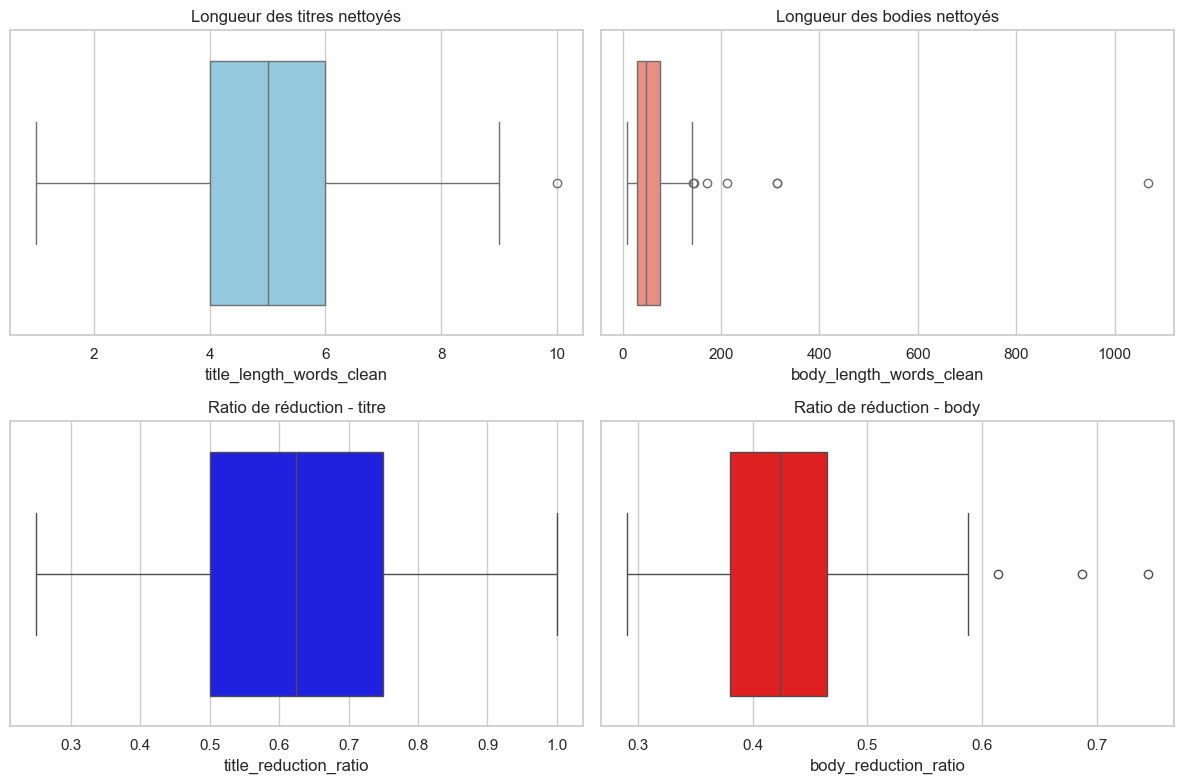

# --- NOMBRE DE QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERS : 91


In [10]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------------------------------
# --- DETECTION DES OUTLIERS PAR LA METHODE DES SEUILS IQR
# ---------------------------------------------------------
sample_explo, sample_outliers = eda.mark_outliers(
    df=sample_explo,
    columns=[
        "title_length_words_clean",
        "body_length_words_clean",
        "title_reduction_ratio",
        "body_reduction_ratio"
    ],
    verbose=True,
    return_outliers=True
)
display(sample_outliers)

# -------------------------------------------
# --- VISUALISATION BOXPLOT DE LA DISPERSION
# -------------------------------------------
eda.plot_boxplots_grid(
    df=sample_explo,
    columns=[
        "title_length_words_clean",
        "body_length_words_clean",
        "title_reduction_ratio",
        "body_reduction_ratio"
    ],
    titles=[
        "Longueur des titres nettoy√©s",
        "Longueur des bodies nettoy√©s",
        "Ratio de r√©duction - titre",
        "Ratio de r√©duction - body"
    ],
    colors=["skyblue", "salmon", "blue", "red"]
)

sample_explo_wo = eda.remove_outliers(sample_explo)
print(f"# --- NOMBRE DE QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERS : {sample_explo_wo.shape[0]}")


Les outliers d√©tect√©s ont √©t√© exclus du corpus utilis√© pour les analyses s√©mantiques et les mod√©lisations, afin de garantir une meilleure homog√©n√©it√© des repr√©sentations textuelles.

---

Bilan de la d√©tection des outliers

La m√©thode des seuils IQR a permis d‚Äôidentifier des questions atypiques sur la base de :

- la longueur des titres nettoy√©s
- la longueur des bodies nettoy√©s
- le ratio de r√©duction des titres
- le ratio de r√©duction des bodies

Les lignes concern√©es ont √©t√© marqu√©es dans le DataFrame `sample_explo` via la colonne `is_outlier`.

Une version filtr√©e sans outliers, `sample_explo_wo`, a √©t√© g√©n√©r√©e pour les √©tapes suivantes d‚Äôanalyse s√©mantique et de mod√©lisation.

> **Nombre de questions restantes apr√®s suppression des outliers :** `sample_explo_wo.shape[0]`

---

‚û°Ô∏è Nous pouvons maintenant passer √† la section suivante : **3.1.5. ANALYSE DES TAGS**


#### **3.1.5. ANALYSE DES TAGS**

##### Pourquoi cette analyse est importante  
Les tags sont les cibles de notre futur mod√®le de classification multi-label.  
Dans cette sous-section, nous explorons leur distribution afin de mieux comprendre la structure des annotations dans le corpus.  
Nous identifions les tags les plus fr√©quents, analysons le nombre moyen de tags par question, et visualisons la r√©partition du nombre de tags.  
Ces observations guideront les choix de filtrage, de pond√©ration et d‚Äô√©valuation dans les √©tapes de mod√©lisation.

| Aspect explor√©              | Utilit√© pour le projet |
|----------------------------|------------------------|
| Distribution des tags      | Comprendre les th√©matiques dominantes |
| Nombre de tags/question    | Identifier les questions mal ou trop annot√©es |
| Tags fr√©quents vs rares    | Pr√©parer la co-occurrence et la supervision |
| Marquage des tags cl√©s     | Cr√©er des variables explicatives pour les mod√®les |


‚û°Ô∏è Nous allons commencer par la **3.1.5.1. Structure des tags**, en v√©rifiant le format de la colonne `Tags` dans `sample_explo_wo`.

##### 3.1.5.1. Structure des tags
- V√©rification du format de la colonne `Tags` (liste, cha√Æne, s√©parateur)
- Nettoyage √©ventuel : conversion en liste de tags

In [11]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# -----------------------------
# --- APERCU DE LA COLONNE TAG
# -----------------------------
print(sample_explo_wo["Tags"].head(10))
print(sample_explo_wo["Tags"].apply(type).value_counts())
# ------------------------------------------
# --- CONVERSION DES CHAINES STRING EN LIST
# ------------------------------------------
sample_explo_wo["Tags"] = sample_explo_wo["Tags"].apply(lambda x: x.split(";"))
sample_explo_wo["Tags"].apply(type).value_counts()




0    algorithm;haskell;hashtable;binary-search-tree...
1    language-agnostic;algorithm;image;image-proces...
2          java;oop;interface;instance;anonymous-class
3    python;matplotlib;seaborn;stacked-bar-chart;gr...
4                          maps;xcode;ios;swift;xcode6
5                 components;maven-2;mojo;plexus;maven
6    javascript;event-driven;frp;reactive-programmi...
7    c++;linker-errors;pure-virtual;vtable;undefine...
8    php;fastcgi;nginx;mod-fastcgi;http-status-code...
9    ide;debugging;intellij-idea;key-bindings;visua...
Name: Tags, dtype: object
Tags
<class 'str'>    91
Name: count, dtype: int64


Tags
<class 'list'>    91
Name: count, dtype: int64

##### 3.1.5.2. Nombre de tags par question  
Objectif : √©tudier combien de tags sont associ√©s √† chaque question, afin de comprendre la granularit√© des annotations et d√©tecter d‚Äô√©ventuelles anomalies (questions sans tag, ou avec trop de tags).  

- Histogramme du nombre de tags par question
- Statistiques descriptives (min, max, moyenne, m√©diane)
- Identification des questions sans tag ou avec un nombre anormalement √©lev√©


In [12]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# -------------------------------
# --- NOMBRE DE TAGS PAR QUESTION
# -------------------------------
sample_explo_wo["NumTags"] = sample_explo_wo["Tags"].apply(len)
# -------------------------------
# --- STATISTIQUES DESCRIPTIVES
sample_explo_wo["NumTags"].describe()
# -------------------------------

count    91.0
mean      5.0
std       0.0
min       5.0
25%       5.0
50%       5.0
75%       5.0
max       5.0
Name: NumTags, dtype: float64

---

Toutes les questions de l‚Äô√©chantillon poss√®dent exactement 5 tags. Cela s‚Äôexplique par deux facteurs :

- Stack Overflow limite le nombre de tags √† **5 par question**
- Le brief de mission demandait explicitement de filtrer les questions avec **au moins 5 tags**, ce qui revient √† ne conserver que celles qui en ont exactement 5

Ma requ√™te SQL contenait cette contrainte :

```sql
WHERE t.TagCount >= 5
```

Mais comme la plateforme limite √† 5 tags, cela revient en pratique √† :

```sql
t.TagCount = 5
```

Cette contrainte garantit une meilleure qualit√© d‚Äôannotation, et par cons√©quent, **l‚Äôanalyse de la variabilit√© du nombre de tags devient caduque**.

> Cette √©tape est donc valid√©e, et n‚Äôapporte pas d‚Äôinformation discriminante dans ce contexte.

---


##### 3.1.5.3. Fr√©quence des tags  
L‚Äôobjectif de cette √©tape est d‚Äôidentifier les tags les plus fr√©quents dans l‚Äô√©chantillon, ainsi que les tags rares. Cela permet de mieux comprendre les th√©matiques dominantes du corpus et de pr√©parer les futures √©tapes de co-occurrence ou de mod√©lisation supervis√©e.

***√âtapes √† r√©aliser :***  

- Aplatissement de la colonne `Tags` (liste de tags par question) en une s√©rie plate de tous les tags
- Comptage des occurrences de chaque tag avec `collections.Counter`
- Conversion en DataFrame tri√© par fr√©quence d√©croissante
- Visualisation des 10 tags les plus fr√©quents
- Identification des tags rares (fr√©quence = 1)

***Ce que cette analyse nous apprend***

| Observation | Interpr√©tation |
|-------------|----------------|
| Tags les plus fr√©quents | Repr√©sentent les th√©matiques dominantes du corpus |
| Tags rares (fr√©quence = 1) | Peuvent √™tre du bruit, des cas sp√©cifiques ou des niches |
| Distribution des fr√©quences | Permet de filtrer, regrouper ou encoder les tags pour la suite |

> Cette √©tape permet de mieux cerner la structure th√©matique du corpus et de pr√©parer les futures analyses de co-occurrence ou de classification.

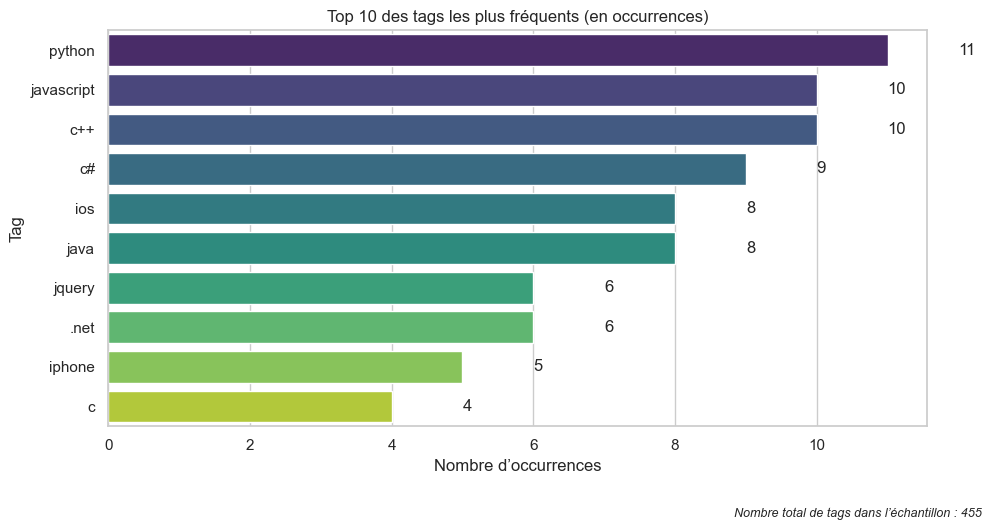

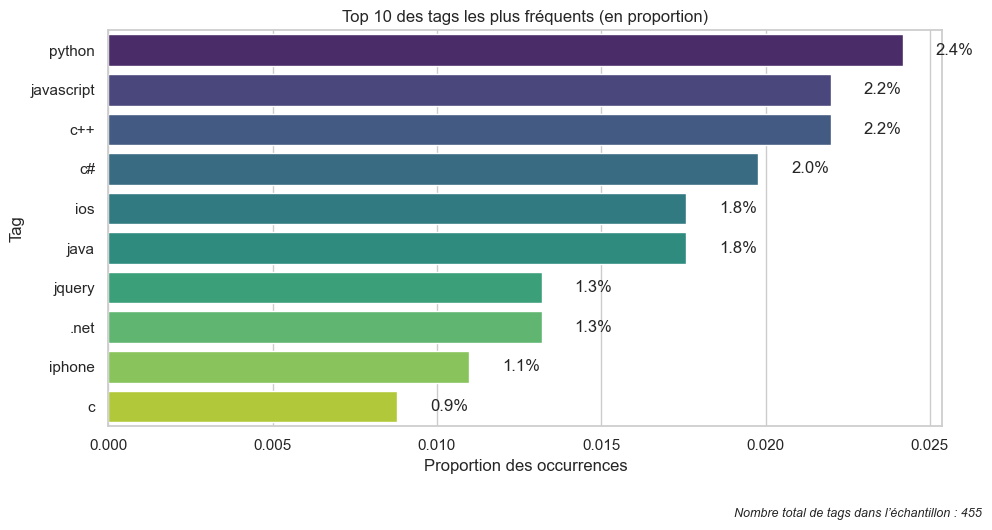

Nombre de tags apparaissant une seule fois : 274


In [13]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)



# --- APLATIR TOUTES LES LISTES DE TAGS
all_tags = [tag for tags in sample_explo_wo["Tags"] for tag in tags]

# --- COMPTER LES OCCURRENCES
tag_counts = Counter(all_tags)

# --- CONVERSION PANDAS POUR VISUALISER
tag_freq_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)
tag_freq_df.reset_index(drop=True, inplace=True)

# --- LES 10 TAGS LES PLUS FREQUENTS
tag_freq_df.head(10)

# --- VISUSALISATION DES TACGS LES PLUS FREQUENTS
eda.plot_tag_occurrences(tag_freq_df, top_n=10)
eda.plot_tag_distribution(tag_freq_df, top_n=10)

# --- TAGS QUI SONT RARES
rare_tags = tag_freq_df[tag_freq_df["Count"] == 1]
print(f"Nombre de tags apparaissant une seule fois : {len(rare_tags)}")

##### 3.1.5.4. Diversit√© des tags  

Cette √©tape vise √† √©valuer la richesse th√©matique du corpus √† travers l‚Äôanalyse de la diversit√© des tags. L‚Äôobjectif est de comprendre si le corpus est domin√© par quelques tags tr√®s fr√©quents ou s‚Äôil pr√©sente une r√©partition plus √©quilibr√©e entre de nombreuses th√©matiques.

Le nombre total de tags distincts a d‚Äôabord √©t√© calcul√©, ce qui donne une premi√®re id√©e de la vari√©t√© des sujets abord√©s. Ensuite, la proportion cumul√©e des tags les plus fr√©quents a √©t√© analys√©e. Cela permet de savoir combien de tags sont n√©cessaires pour couvrir une certaine part du corpus, par exemple 80‚ÄØ%. Une courbe de couverture cumulative a √©t√© trac√©e pour visualiser cette dynamique : plus la courbe monte rapidement, plus le corpus est concentr√© autour de quelques tags.

> Exemple d‚Äôinterpr√©tation :

| Indicateur | Signification |
|------------|---------------|
| 50 tags couvrent 80‚ÄØ% des occurrences | Forte concentration th√©matique |
| 200 tags couvrent 80‚ÄØ% des occurrences | Corpus plus diversifi√© |

En compl√©ment, une mesure quantitative de la diversit√© a √©t√© utilis√©e : l‚Äôentropie de Shannon. Cette mesure permet de r√©sumer en un seul chiffre la dispersion de la distribution des tags. Une entropie proche de z√©ro indique que quelques tags dominent largement (faible diversit√©), tandis qu‚Äôune entropie √©lev√©e indique une r√©partition plus √©quilibr√©e (forte diversit√©). L‚Äôentropie maximale th√©orique correspond √† une distribution parfaitement uniforme, o√π tous les tags apparaissent avec la m√™me fr√©quence. En comparant l‚Äôentropie observ√©e √† cette valeur maximale, on obtient un taux de diversit√© relative, exprim√© en pourcentage.

> Interpr√©tation de l‚Äôentropie :

| Valeur d‚Äôentropie | Interpr√©tation |
|-------------------|----------------|
| Proche de 0       | Corpus tr√®s concentr√© (peu de diversit√©) |
| Moyenne (ex. 2‚Äì3) | Diversit√© mod√©r√©e, quelques tags dominants |
| Proche de log‚ÇÇ(N) | Corpus tr√®s diversifi√©, distribution √©quilibr√©e |

> Exemple :  
> Une entropie de 2.5 bits sur un maximum possible de 4.3 bits donne un taux de diversit√© relative de 58‚ÄØ%. Cela signifie que la distribution des tags est assez concentr√©e, mais pas totalement polaris√©e.

Cette analyse permet de mieux comprendre la structure s√©mantique du corpus. Elle est utile pour anticiper les choix de mod√©lisation, comme le filtrage des tags rares, le regroupement th√©matique ou l‚Äôencodage multi-label.

> Cette √©tape fournit une vision synth√©tique de la richesse et de la concentration des th√©matiques dans le corpus, et pr√©pare le terrain pour l‚Äô√©tude des co-occurrences et la mod√©lisation supervis√©e.




Nombre de tags distincts dans l‚Äô√©chantillon : 327


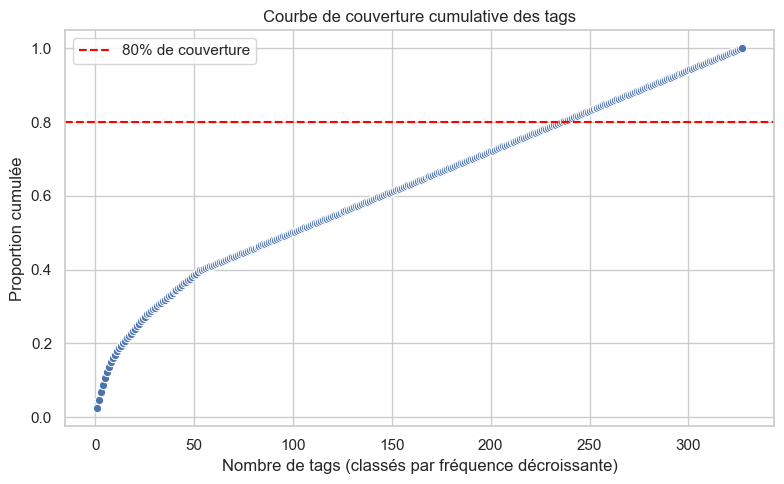

Nombre de tags n√©cessaires pour couvrir 80% des occurrences : 236
Entropie de la distribution des tags : 8.0204 bits
Entropie maximale possible : 8.3531 bits
Taux de diversit√© relative : 96.02%


In [14]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --- NOMBRE DE TAGS DISTINCTS
nb_tags_uniques = tag_freq_df["Tag"].nunique()
print(f"Nombre de tags distincts dans l‚Äô√©chantillon : {nb_tags_uniques}")

# --- CALCUL DE LA PROPORTION CUMULEE
tag_freq_df["Proportion"] = tag_freq_df["Count"] / tag_freq_df["Count"].sum()
tag_freq_df["Cumulative"] = tag_freq_df["Proportion"].cumsum()

# --- VISUALISATION  : COURBE DE COUVERTURE CUMULATIVE
plt.figure(figsize=(8, 5))
sns.lineplot(data=tag_freq_df, x=range(1, len(tag_freq_df)+1), y="Cumulative", marker="o")
plt.axhline(0.8, color="red", linestyle="--", label="80% de couverture")
plt.title("Courbe de couverture cumulative des tags")
plt.xlabel("Nombre de tags (class√©s par fr√©quence d√©croissante)")
plt.ylabel("Proportion cumul√©e")
plt.legend()
plt.tight_layout()
plt.show()

# --- NOMBRE DE TAGS NECESSAIRE POUR COUVRIR 80% DU CORPUS
nb_tags_80 = (tag_freq_df["Cumulative"] <= 0.8).sum()
print(f"Nombre de tags n√©cessaires pour couvrir 80% des occurrences : {nb_tags_80}")

# ----------------------------------
# --- CALCUL DE L'ENTROPIE DES TAGS
# ----------------------------------
# --- DISTRIBUTION DES PROPORTIONS
proportions = tag_freq_df["Proportion"].values

# --- ENTROPIE DE SHANNON (BASE 2)
tag_entropy = entropy(proportions, base=2)
print(f"Entropie de la distribution des tags : {tag_entropy:.4f} bits")

# --------------------------------
# --- ENTROPIE MAXIMALE THEORIQUE
# --------------------------------
max_entropy = np.log2(len(proportions))
print(f"Entropie maximale possible : {max_entropy:.4f} bits")
print(f"Taux de diversit√© relative : {tag_entropy / max_entropy:.2%}")


***Interpr√©tation des r√©sultats sur la diversit√© des tags (√©chantillon de 100 questions)***  

L‚Äôanalyse de la diversit√© des tags sur un √©chantillon de 100 questions r√©v√®le une distribution particuli√®rement √©quilibr√©e et riche. On observe :

- **327 tags distincts**, ce qui t√©moigne d‚Äôune grande vari√©t√© th√©matique.
- Il faut **236 tags** pour couvrir 80‚ÄØ% des occurrences, ce qui indique une absence de concentration autour de quelques tags dominants.
- L‚Äô**entropie de Shannon** est tr√®s √©lev√©e (**8.0024 bits**), proche de l‚Äôentropie maximale th√©orique (**8.3531 bits**), soit un **taux de diversit√© relative de 96.02‚ÄØ%**.

> Ces r√©sultats sugg√®rent que le corpus est extr√™mement diversifi√©, avec une r√©partition quasi uniforme des tags. Il ne semble pas y avoir de th√©matiques √©crasantes, ce qui pourrait rendre la mod√©lisation plus complexe mais aussi plus riche.

‚ö†Ô∏è **Attention toutefois** : ces r√©sultats ont √©t√© obtenus √† partir d‚Äôun √©chantillon r√©duit de 100 questions. Ils donnent une premi√®re intuition sur la structure du corpus, mais **ne peuvent pas √™tre g√©n√©ralis√©s sans validation** sur un √©chantillon plus large, voire sur l‚Äôensemble des 50‚ÄØ000 questions. Il est donc n√©cessaire de relativiser cette interpr√©tation et de la consid√©rer comme **exploratoire**.

>  Une analyse √† plus grande √©chelle permettra de confirmer (ou non) ces tendances et d‚Äô√©valuer la stabilit√© des indicateurs de diversit√©.


##### 3.1.5.5. Marquage des tags dominants  

***Objectif :*** identifier les tags les plus repr√©sentatifs du corpus afin de structurer les analyses ult√©rieures, comme :

- l‚Äô√©tude des co-occurrences
- la r√©duction de la dimensionnalit√©
- la mod√©lisation supervis√©e multi-label


Les r√©sultats pr√©c√©dents ont montr√© que la distribution des tags est particuli√®rement √©tal√©e :

| Indicateur | Valeur observ√©e |
|------------|------------------|
| Tags n√©cessaires pour couvrir 80‚ÄØ% des occurrences | 236 |
| Entropie de Shannon | 8.00 bits |
| Taux de diversit√© relative | 96‚ÄØ% |

Dans ce contexte, il ne serait pas pertinent de ne retenir que les 10 ou 20 premiers tags : cela ne refl√®terait pas la structure r√©elle du corpus.  

***Strat√©gie retenue***  

Le marquage des tags dominants repose sur deux crit√®res combin√©s :

1. **Fr√©quence minimale d‚Äôapparition**  
   Seuls les tags apparaissant suffisamment souvent sont consid√©r√©s comme √©ligibles.  
   Le seuil est calcul√© dynamiquement comme suit :  
   - 0.1‚ÄØ% du nombre total de questions  
   - avec un **seuil plancher param√©trable**, actuellement fix√© √† **3** (mais un seuil de **4** est √©galement envisageable pour plus de robustesse)

2. **Couverture cumulative**  
   Parmi les tags √©ligibles, on s√©lectionne ceux qui permettent de couvrir une proportion cible du corpus (ex. 80‚ÄØ%).  
   Le tag qui d√©passe juste ce seuil est √©galement inclus pour √©viter une coupure artificielle.

***Avantages de cette m√©thode***  

- S‚Äôadapte √† la taille et √† la structure du corpus
- √âcarte les tags trop rares ou anecdotiques
- Conserve une diversit√© th√©matique suffisante
- Pr√©pare efficacement les √©tapes suivantes de l‚Äôanalyse

> Cette m√©thode constitue une base solide pour les analyses √† venir, en assurant un bon compromis entre repr√©sentativit√©, diversit√© et stabilit√©.


['python',
 'javascript',
 'c++',
 'c#',
 'ios',
 'java',
 'jquery',
 '.net',
 'iphone',
 'c',
 'linux',
 'html',
 'xcode',
 'django',
 'ruby-on-rails',
 'algorithm',
 'node.js',
 'performance',
 'gcc',
 'memory-management',
 'dictionary',
 'objective-c',
 'hibernate',
 'css',
 'entity-framework',
 'image-processing']

Tag  Count  Proportion  Cumulative  is_dominant_tag
0              python     11    0.024176    0.024176             True
1          javascript     10    0.021978    0.046154             True
2                 c++     10    0.021978    0.068132             True
3                  c#      9    0.019780    0.087912             True
4                 ios      8    0.017582    0.105495             True
5                java      8    0.017582    0.123077             True
6              jquery      6    0.013187    0.136264             True
7                .net      6    0.013187    0.149451             True
8              iphone      5    0.010989    0.160440             True
9                   c      4    0.008791    0.169231             True
10              linux      4    0.008791    0.178022             True
11               html      4    0.008791    0.186813             True
12              xcode      3    0.006593    0.193407             True
13             django      3    0.006593    0.200000             True
14      ruby-on-rails      3    0.006593    0.206593             True
15          algorithm      3    0.006593    0.213187             True
16            node.js      3    0.006593    0.219780             True
17        performance      3    0.006593    0.226374             True
18                gcc      3    0.006593    0.232967             True
19  memory-management      3    0.006593    0.239560             True
20         dictionary      3    0.006593    0.246154             True
21        objective-c      3    0.006593    0.252747             True
22          hibernate      3    0.006593    0.259341             True
23                css      3    0.006593    0.265934             True
24   entity-framework      3    0.006593    0.272527             True
25   image-processing      3    0.006593    0.279121             True

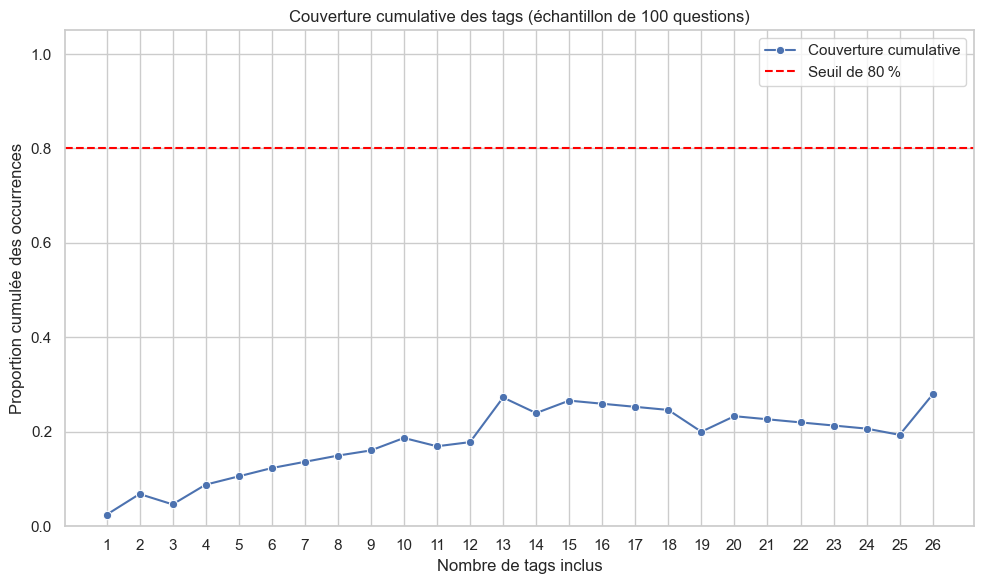

In [15]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------
# --- MARQUAGE DES TAGS DOMINANTS
# --------------------------------
tag_freq_df_marked, dominant_tags = eda.mark_dominant_tags_by_frequency_and_coverage(
    tag_freq_df,
    nb_questions=100,  # ou 50000 plus tard
    min_coverage=0.8,
    min_count_floor=3
)

display(dominant_tags)
display(tag_freq_df_marked)

eda.plot_tag_coverage(tag_freq_df_marked, coverage_target=0.8, title_suffix="√©chantillon de 100 questions")


***INTERPRETATION DE LA COUVERTURE CUMULATIVE***  
La courbe obtenue montre une mont√©e lente et r√©guli√®re de la couverture cumulative, ce qui confirme une distribution tr√®s √©tal√©e des tags dans l‚Äô√©chantillon. M√™me en abaissant le seuil plancher √† 3 occurrences, seuls 26 tags ont pu √™tre marqu√©s comme dominants, et leur couverture cumul√©e reste inf√©rieure √† 30‚ÄØ% (~27.9‚ÄØ%).

Cela indique que le corpus est extr√™mement diversifi√©, avec peu de redondance entre les tags. Aucun tag ne domine massivement, et de nombreux tags apparaissent √† fr√©quence mod√©r√©e ou faible. On observe une grande vari√©t√© de th√©matiques : langages (`python`, `c++`, `javascript`), frameworks (`django`, `ruby-on-rails`), outils (`xcode`, `gcc`), ou concepts (`memory-management`, `algorithm`).

>  Cette dispersion confirme que le marquage des tags dominants ne peut pas reposer sur un simple top N. Elle justifie pleinement l‚Äôapproche par fr√©quence minimale et couverture cumulative, et souligne l‚Äôint√©r√™t d‚Äôun filtrage intelligent pour les √©tapes de mod√©lisation √† venir.


#### **3.1.6. CO-OCCURRENCE DES TAGS**

Certains tags apparaissent fr√©quemment ensemble dans les questions Stack Overflow, r√©v√©lant des th√©matiques ou technologies souvent associ√©es.  
L‚Äôobjectif de cette section est d‚Äôexplorer ces relations √† travers une analyse de co-occurrence, afin de :

- d√©tecter des affinit√©s th√©matiques (ex. `python` + `django`)
- rep√©rer des clusters naturels de sujets
- identifier des tags ‚Äúponts‚Äù entre domaines (ex. `performance`, `algorithm`)
- enrichir l‚Äôinterpr√©tation des clusters ou am√©liorer la suggestion de tags

L‚Äôanalyse portera sur un sous-ensemble de **tags plus fr√©quents**, identifi√©s √† l‚Äôaide d‚Äôun seuil de fr√©quence minimale.  
Bien que la diversit√© du corpus emp√™che de d√©finir des ‚Äútags dominants‚Äù au sens strict, ce filtrage permet de se concentrer sur les th√©matiques les plus repr√©sentatives et r√©currentes.

Nous proc√©derons en deux √©tapes :

1. **Construction d‚Äôune matrice de co-occurrence** binaire (pr√©sence conjointe dans une m√™me question)
2. **Visualisation optionnelle** sous forme de heatmap ou de graphe pour mettre en √©vidence les couples de tags les plus li√©s



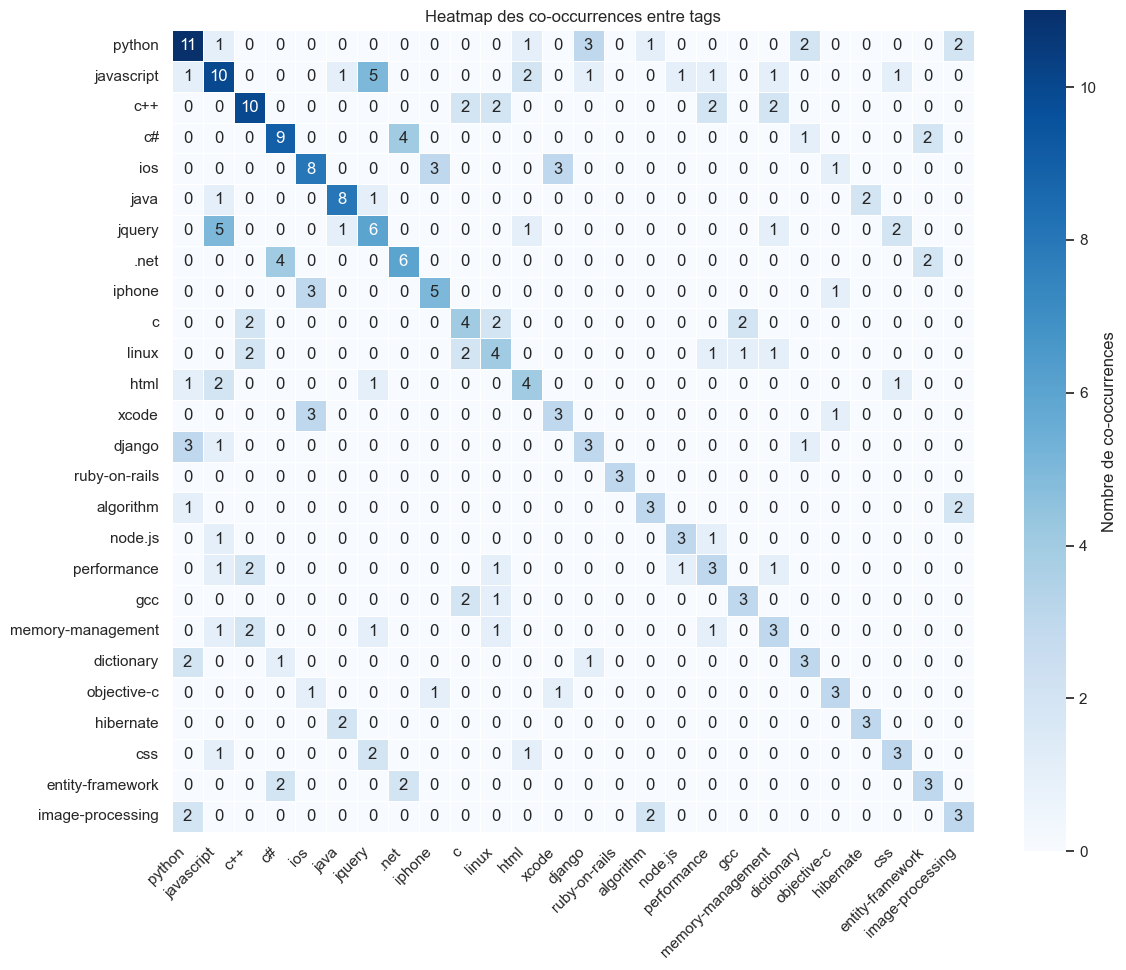

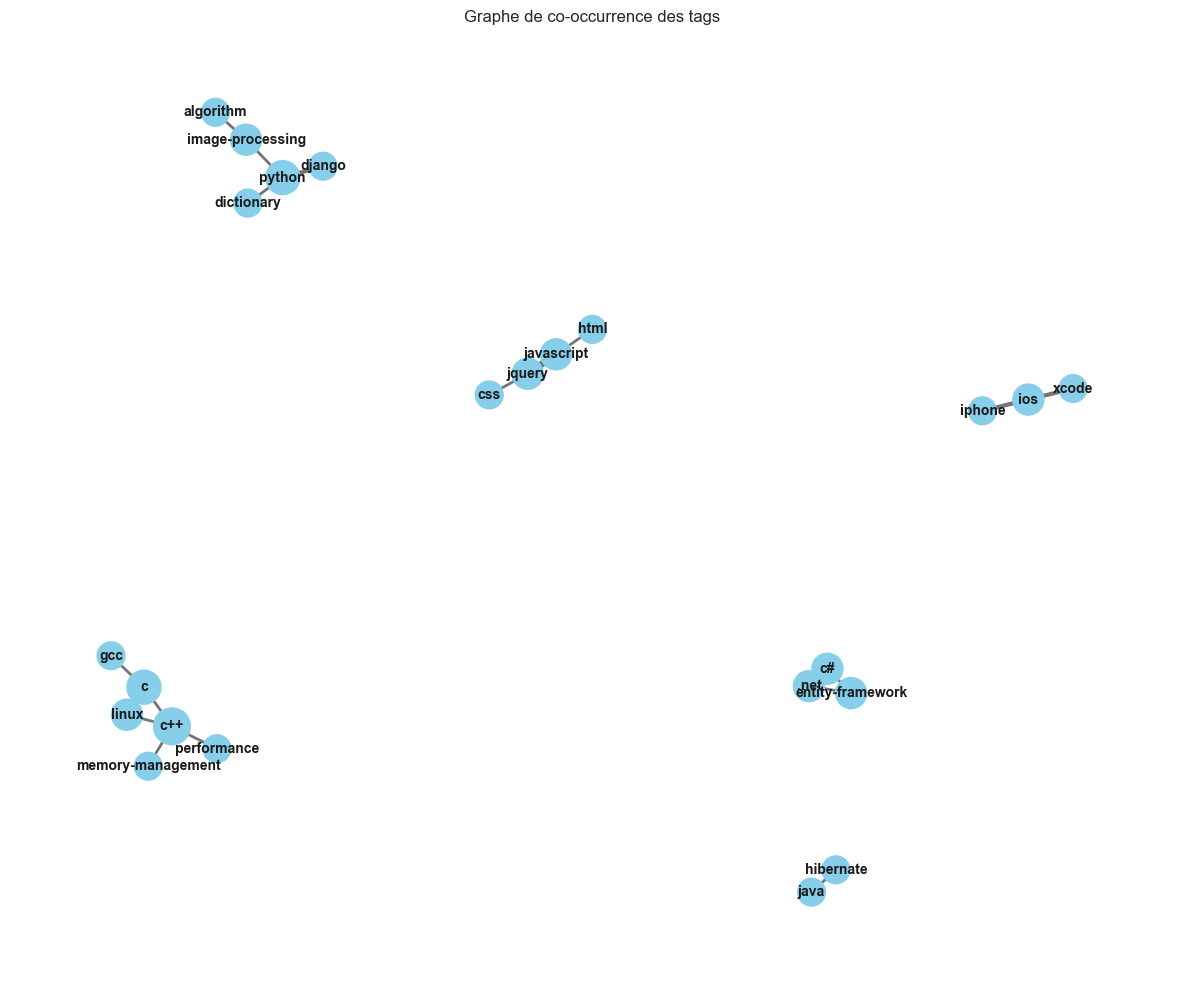

In [16]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

cooc_matrix, tag_matrix = eda.build_tag_cooccurrence_matrix(
    df_questions=sample_explo_wo,  # ou le nom de ton DataFrame
    dominant_tags=dominant_tags,
    tag_col="Tags"
)

cooc_matrix.style.background_gradient(cmap="Blues")

eda.plot_tag_cooccurrence_heatmap(cooc_matrix)

eda.plot_tag_cooccurrence_graph(cooc_matrix, min_edge_weight=2, layout="spring")


***INTERPRETATION***

L‚Äôanalyse crois√©e de la heatmap et du graphe de co-occurrence permet de r√©v√©ler la structure th√©matique sous-jacente du corpus.

**HEATMAP**  
La heatmap met en √©vidence les intensit√©s de co-occurrence entre tags. On y observe :

- Une diagonale dominante (fr√©quence individuelle des tags)
- Quelques associations fortes hors diagonale, notamment :
  - `python` avec `django` ou `algorithm`
  - `c++` avec `memory-management` ou `gcc`
  - `javascript` avec `jquery`
  - `c#` avec `.net` ou `entity-framework`
- Une majorit√© de cellules claires, indiquant que la plupart des couples de tags co-occurrent rarement

Cela confirme la diversit√© du corpus et la relative raret√© des combinaisons r√©currentes.

**GRAPHE DE CO-OCCURRENCE**

Le graphe offre une repr√©sentation plus intuitive des relations entre tags. Il r√©v√®le :

- Des **clusters th√©matiques nets**, comme :
  - Python et data (`python`, `django`, `algorithm`, `dictionary`)
  - Web frontend (`html`, `css`, `javascript`, `jquery`)
  - D√©veloppement mobile iOS (`ios`, `iphone`, `xcode`)
  - Syst√®mes bas niveau (`c`, `c++`, `linux`, `gcc`, `performance`)
  - Java backend (`java`, `hibernate`)
  - .NET (`c#`, `entity-framework`)
- Des **hubs technologiques**, comme `python`, `c++` ou `javascript`
- Des **ponts s√©mantiques** entre domaines, r√©v√©lant des affinit√©s inattendues

> Cette double visualisation permet d‚Äôidentifier des familles technologiques coh√©rentes, de rep√©rer des th√©matiques centrales, et de poser les bases d‚Äôune segmentation th√©matique plus fine du corpus.

**L‚Äôanalyse de co-occurrence** a permis de r√©v√©ler les principales associations th√©matiques pr√©sentes dans le corpus.  
Gr√¢ce √† la heatmap et au graphe, plusieurs regroupements coh√©rents ont √©merg√© (langages, frameworks, outils, concepts), confirmant la richesse et la diversit√© du jeu de donn√©es.

Cette √©tape a permis de :

- Mettre en √©vidence des **clusters technologiques naturels**
- Identifier des **hubs** et des **ponts s√©mantiques**
- Poser les bases d‚Äôune **repr√©sentation structur√©e** du corpus

> Ces r√©sultats serviront de socle pour les √©tapes suivantes, notamment la vectorisation des tags, la r√©duction de dimensionnalit√©, et la mod√©lisation supervis√©e.

Nous passons maintenant √† la phase de **Feature Engineering**, o√π nous allons transformer ces structures en variables exploitables pour les mod√®les.




## **4. FEATURE ENGINEERING**  

Cette section vise √† transformer les textes nettoy√©s en repr√©sentations num√©riques exploitables par des mod√®les de machine learning.  
Nous testons plusieurs m√©thodes de vectorisation (TF-IDF, embeddings) ainsi que l‚Äôencodage des tags pour la classification multi-label.  
Comme pour l‚Äôexploration, toutes les √©tapes sont d‚Äôabord appliqu√©es √† un √©chantillon de 100 questions (`sample_df`) avant d‚Äô√™tre g√©n√©ralis√©es √† l‚Äôensemble du corpus (`brut_df`).

***Plan de la section***  

4.1.1. Vectorisation TF-IDF  
4.1.2. R√©duction de dimension (SVD, PCA)  
4.1.3. Embeddings  
4.1.4. Encodage des tags (MultiLabelBinarizer)

### **4.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

#### **4.1.1. VECTORISATION TF-IDF**

**Objectif:**  
Transformer le texte en vecteurs pond√©r√©s.  
Dans cette sous-section, nous appliquons la m√©thode **TF-IDF** (Term Frequency ‚Äì Inverse Document Frequency) pour transformer les textes nettoy√©s (`clean_title` et `clean_body`) en vecteurs num√©riques.

Cette repr√©sentation permet de :

- pond√©rer les mots en fonction de leur importance relative dans le corpus
- valoriser les termes sp√©cifiques √† un document
- att√©nuer l‚Äôimpact des mots trop fr√©quents (bruit lexical)

Les vecteurs obtenus serviront de base pour la **mod√©lisation non supervis√©e** (LDA, clustering) ou **supervis√©e** (classification multi-label).

***√âtapes √† suivre***

1. **Construction des matrices TF-IDF** √† partir de `clean_title` et `clean_body`
2. **Visualisation des mots les plus informatifs** (poids TF-IDF √©lev√©s)
3. **R√©duction du vocabulaire** (filtrage par fr√©quence, stopwords, etc.)

> Toutes les exp√©rimentations sont d‚Äôabord men√©es sur l‚Äô√©chantillon `sample_explo_wo` avant d‚Äô√™tre g√©n√©ralis√©es √† l‚Äôensemble du corpus `brut_df`.



Shape de la matrice TF-IDF (title) : (91, 66)
Top 15 mots (title) par poids TF-IDF :
file: 3.45
create: 3.43
class: 3.04
python: 3.03
cursor: 2.78
difference: 2.58
object: 2.49
static: 2.17
value: 2.05
stream: 2.00
method: 1.95
spring: 1.79
image: 1.75
django: 1.71
memory: 1.71


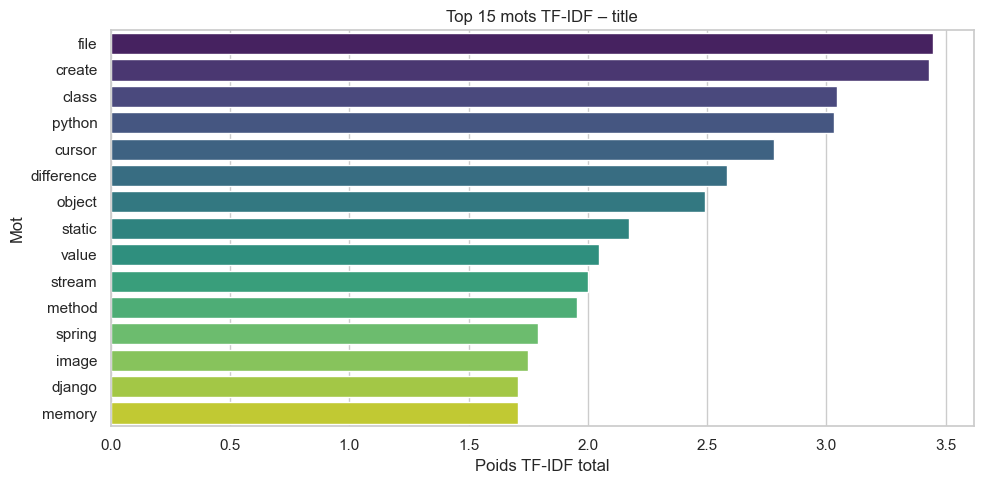

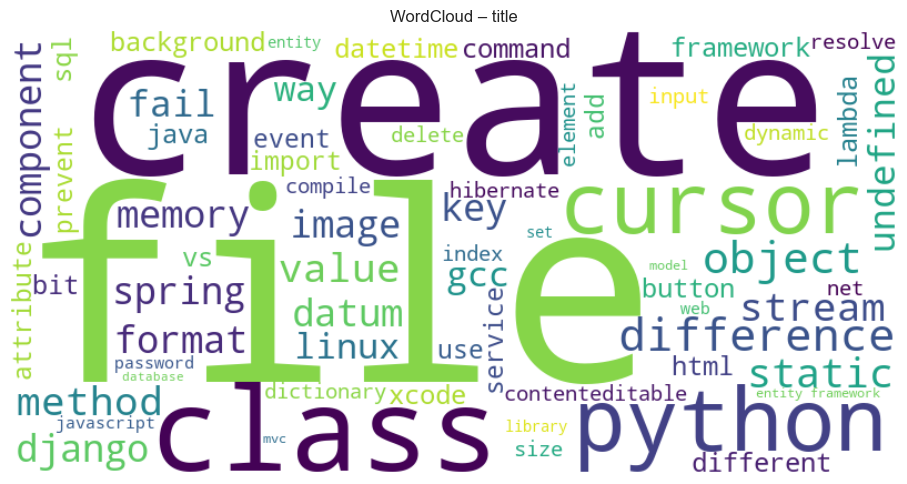

Shape de la matrice TF-IDF (body) : (91, 552)
Top 15 mots (body) par poids TF-IDF :
class: 3.89
like: 3.77
use: 3.28
image: 3.14
way: 3.12
file: 2.95
model: 2.79
time: 2.77
want: 2.63
static: 2.54
error: 2.54
need: 2.54
code: 2.52
new: 2.48
work: 2.45


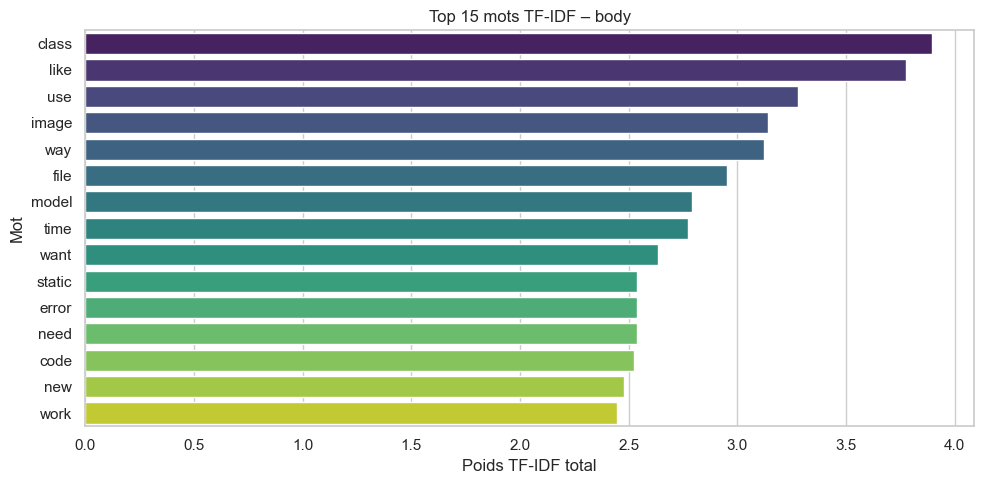

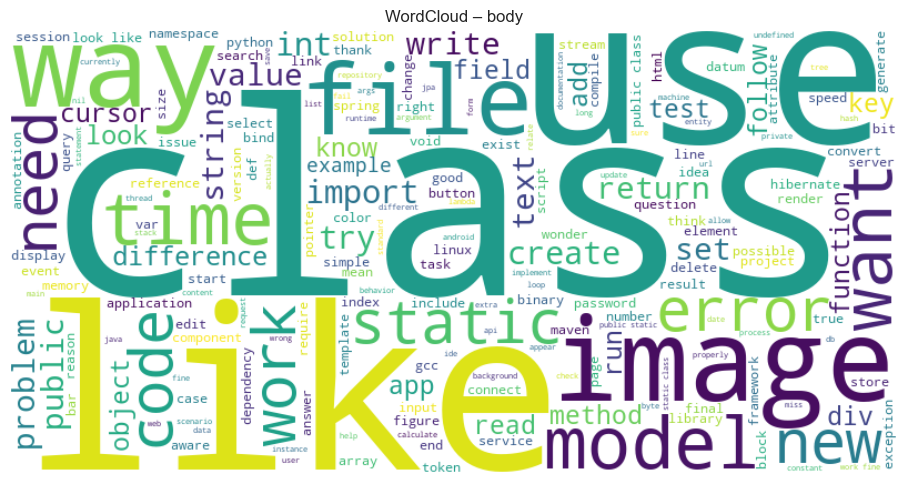

Shape de la matrice TF-IDF (title + body) : (91, 572)
Top 15 mots (title + body) par poids TF-IDF :
class: 3.91
like: 3.34
image: 3.15
file: 3.12
use: 3.12
way: 2.90
static: 2.67
model: 2.65
create: 2.59
time: 2.54
import: 2.34
new: 2.34
want: 2.26
code: 2.25
work: 2.24


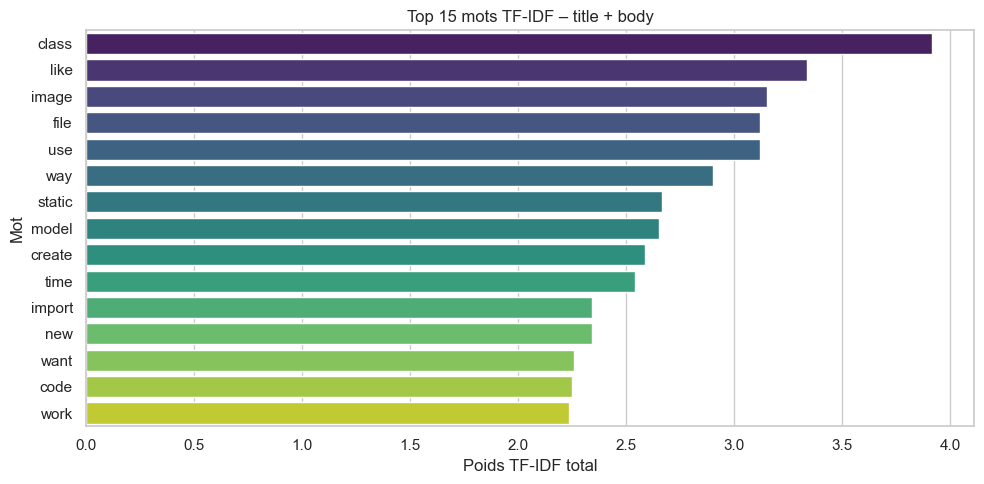

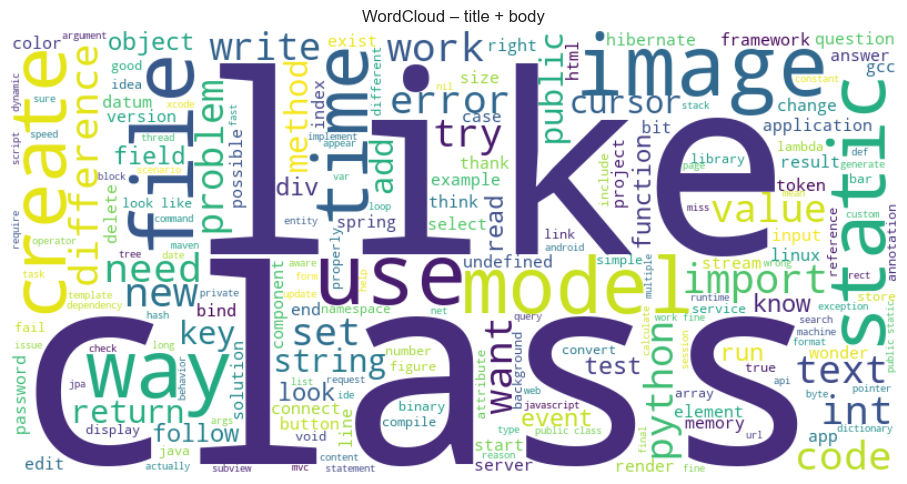

In [17]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------------
# --- VECTORISATION DES TITRES NETTOYES
# --------------------------------------
X_title_tfidf, title_vocab, top_title_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_title"], label="title"
)

# --------------------------------------
# --- VECTORISATION DES CORPS NETTOYES
# --------------------------------------
X_body_tfidf, body_vocab, top_body_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_body"], label="body"
)
# ----------------------------------------------
# --- VECTORISATION DE TITRES + COPRS FUSIONNES
# ----------------------------------------------
# --- ON FUSIONNE TITLE ET BODY
sample_explo_wo["clean_title_body"] = (
    sample_explo_wo["clean_title"].fillna("") + " " + sample_explo_wo["clean_body"].fillna("")
)
# --- VECTORISATION SUR clean_title_body
X_titlebody_tfidf, titlebody_vocab, top_titlebody_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_title_body"],
    label="title + body"
)


#### **4.1.2. REDUCTION DE DIMENSION (SVD, PCA)**

**Objectif:**  
Visualiser ou compresser les vecteurs  

Les repr√©sentations vectorielles issues de TF-IDF sont souvent tr√®s dimensionnelles et creuses.  
Dans cette sous-section, nous appliquons des techniques de r√©duction de dimension telles que TruncatedSVD (adapt√© aux matrices creuses) ou PCA (sur matrices denses) afin de :
- Visualiser les documents dans un espace 2D ou 3D
- R√©duire la complexit√© pour certains algorithmes
- Identifier des regroupements th√©matiques potentiels

Cette √©tape est particuli√®rement utile pour l‚Äôexploration visuelle ou comme pr√©traitement pour des mod√®les non supervis√©s.


Explained variance (title) : 7.28%


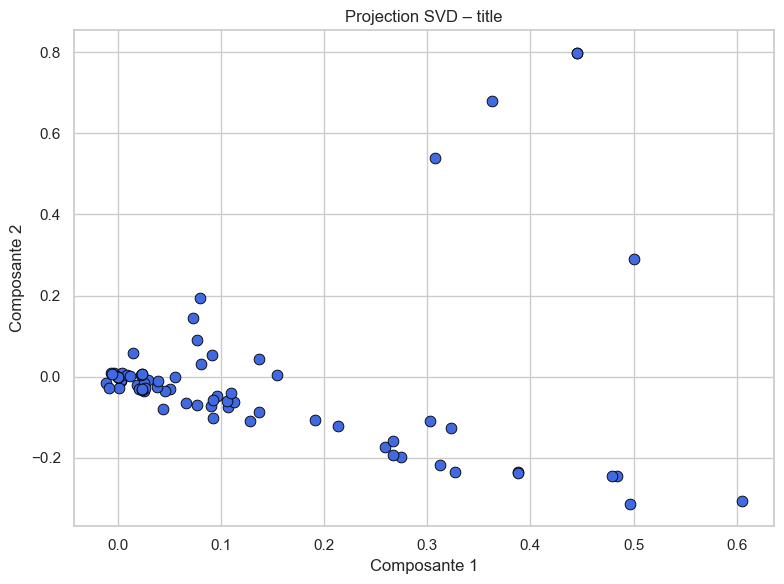

Explained variance (body) : 3.65%


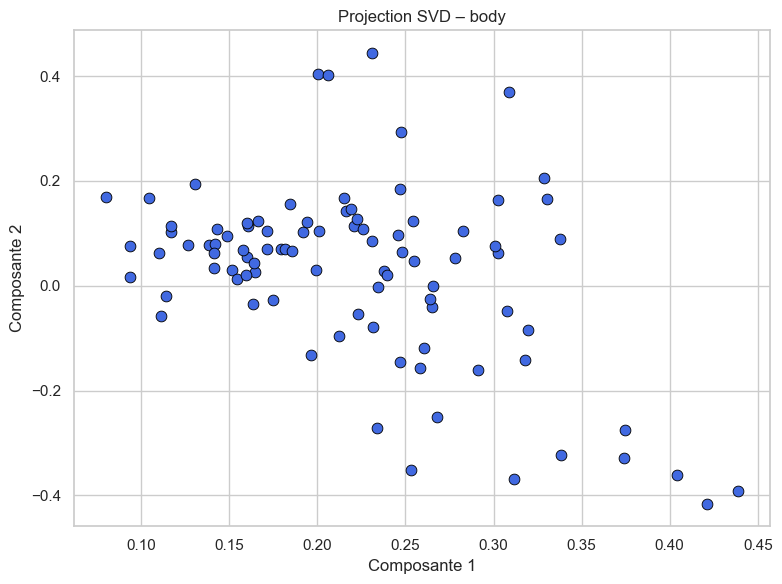

Explained variance (title + body) : 3.61%


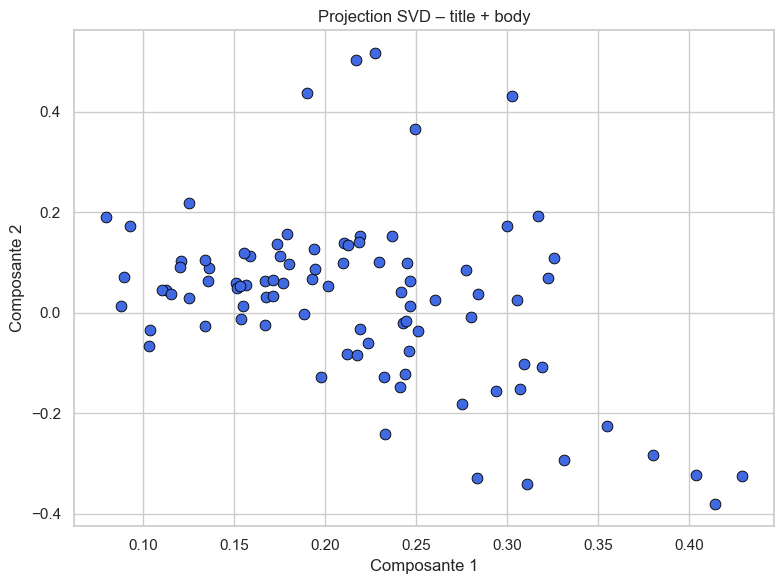

In [18]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------------
# --- REDUCTION DIMENSIONS SVD DES TITRES NETTOYES
# --------------------------------------
X_title_svd, svd_title = eda.apply_svd_and_plot(X_title_tfidf, label="title")
# --------------------------------------
# --- REDUCTION DIMENSIONS SVD DES CORPS NETTOYES
# --------------------------------------
X_body_svd, svd_body = eda.apply_svd_and_plot(X_body_tfidf, label="body")
# ----------------------------------------------
# --- REDUCTION DIMENSIONS SVD DE TITRES + COPRS FUSIONNES
# ----------------------------------------------
X_titlebody_svd, svd_titlebody = eda.apply_svd_and_plot(X_titlebody_tfidf, label="title + body")

Variance expliqu√©e cumul√©e (title) :
 - 10 composantes : 33.05%
 - 20 composantes : 58.14%
 - 50 composantes : 97.61%


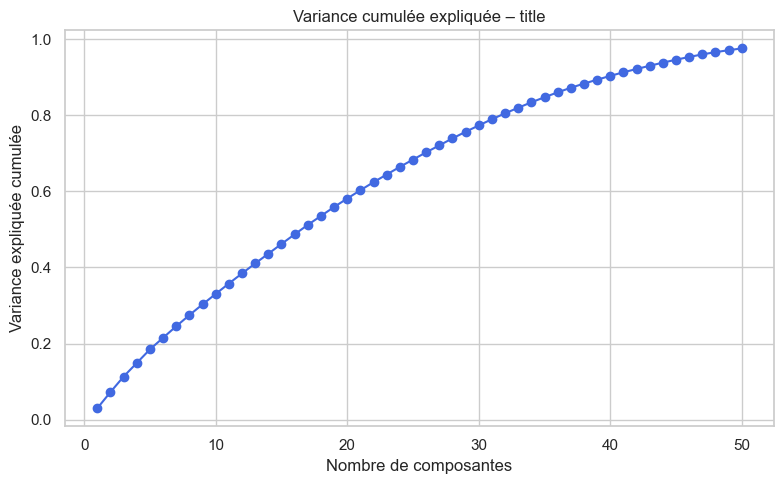

Variance expliqu√©e cumul√©e (body) :
 - 10 composantes : 21.64%
 - 20 composantes : 38.72%
 - 50 composantes : 74.43%


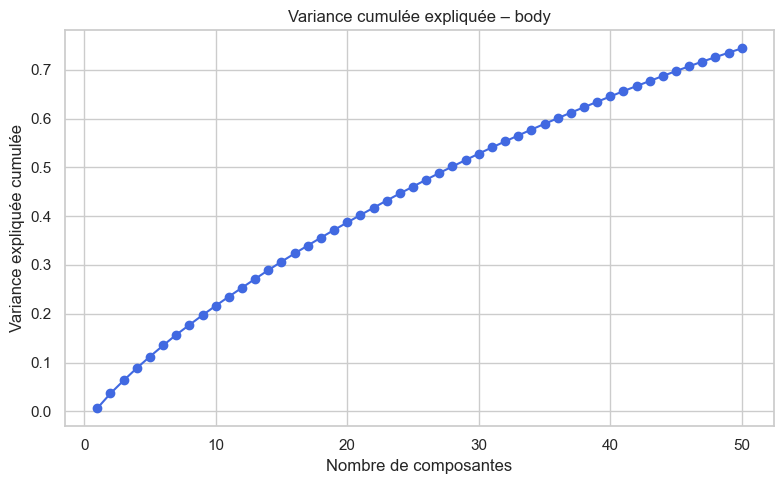

Variance expliqu√©e cumul√©e (title + body) :
 - 10 composantes : 21.39%
 - 20 composantes : 38.46%
 - 50 composantes : 74.44%


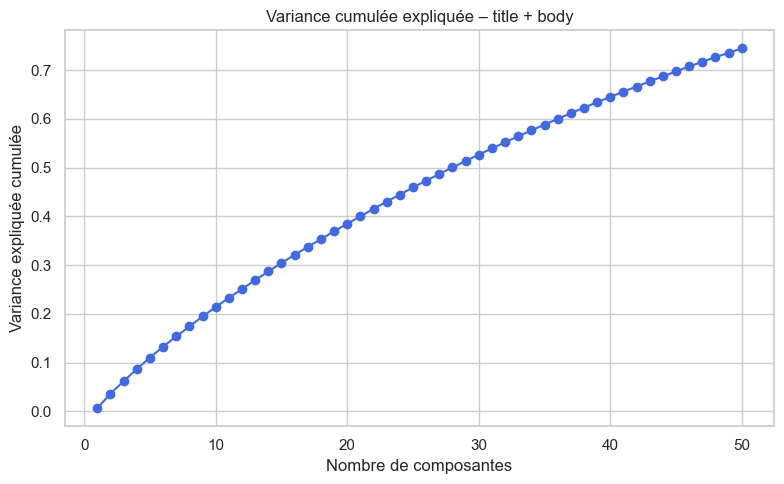

In [19]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# SVD avec 100 composantes
X_title_svd100, svd_title100 = eda.apply_svd_variance(X_title_tfidf, label="title", n_components=50)
X_body_svd100, svd_body100 = eda.apply_svd_variance(X_body_tfidf, label="body", n_components=50)
X_titlebody_svd100, svd_titlebody100 = eda.apply_svd_variance(X_titlebody_tfidf, label="title + body", n_components=50)


#### **4.1.3. EMBEDDINGS**

**Objectif:**  
Repr√©sentations denses et contextuelles  

Les embeddings sont des repr√©sentations vectorielles denses et continues qui capturent les relations s√©mantiques entre les mots.  
Contrairement √† TF-IDF, qui repose sur des fr√©quences, les embeddings permettent de repr√©senter le sens des mots dans leur contexte.  
Dans cette sous-section, nous explorons diff√©rentes approches d‚Äôembeddings, notamment :
- Word2Vec (bas√© sur la co-occurrence locale)
- GloVe (bas√© sur la co-occurrence globale)
- BERT ou autres mod√®les de type transformer (contextualis√©s)

Ces repr√©sentations sont particuli√®rement utiles pour des mod√®les profonds ou pour am√©liorer la qualit√© des suggestions de tags.



1. Word2Vec,  
2. BERT,  
3. etc

##### 4.1.3.1. METHODE SBERT

In [20]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --- PREPARATION DES CORPUS
corpus_title = sample_explo_wo["clean_title"].fillna("").tolist()
corpus_body = sample_explo_wo["clean_body"].fillna("").tolist()
corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()
# --- ENCODAGE SBERT VIA API
embeddings_title = [get_embedding(text, model="sbert") for text in tqdm(corpus_title, desc="SBERT ‚Äì title")]
embeddings_body = [get_embedding(text, model="sbert") for text in tqdm(corpus_body, desc="SBERT ‚Äì body")]
embeddings_titlebody = [get_embedding(text, model="sbert") for text in tqdm(corpus_titlebody, desc="SBERT ‚Äì title+body")]


SBERT ‚Äì title:   0%|          | 0/91 [00:00<?, ?it/s]

SBERT ‚Äì body:   0%|          | 0/91 [00:00<?, ?it/s]

SBERT ‚Äì title+body:   0%|          | 0/91 [00:00<?, ?it/s]

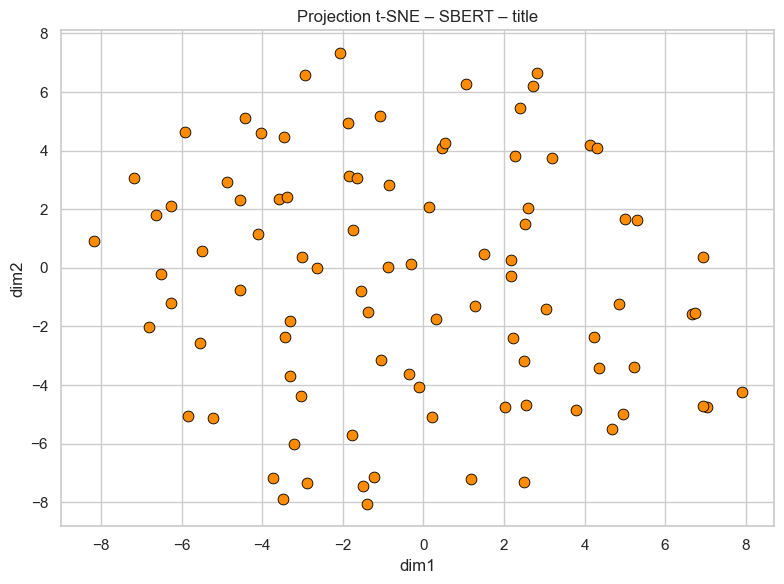

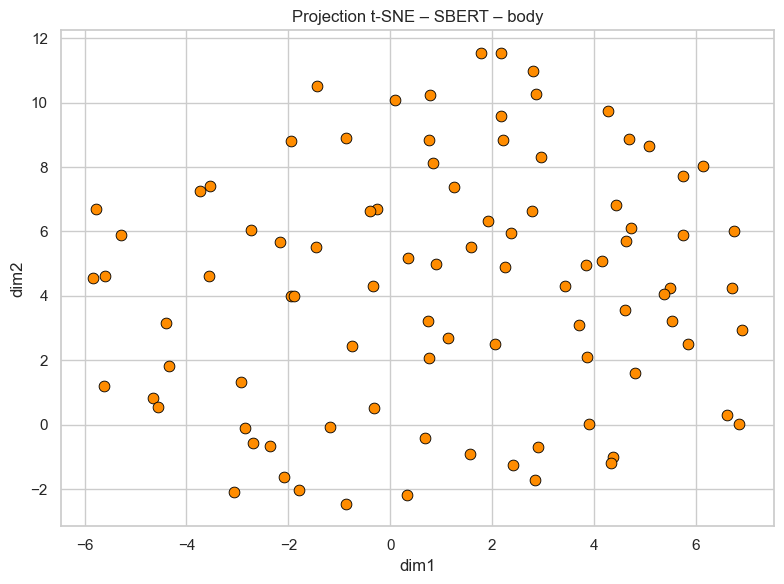

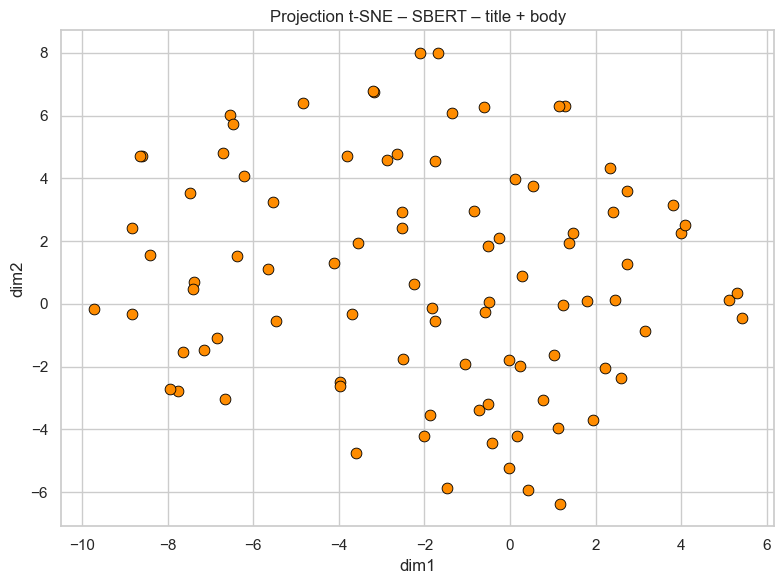

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


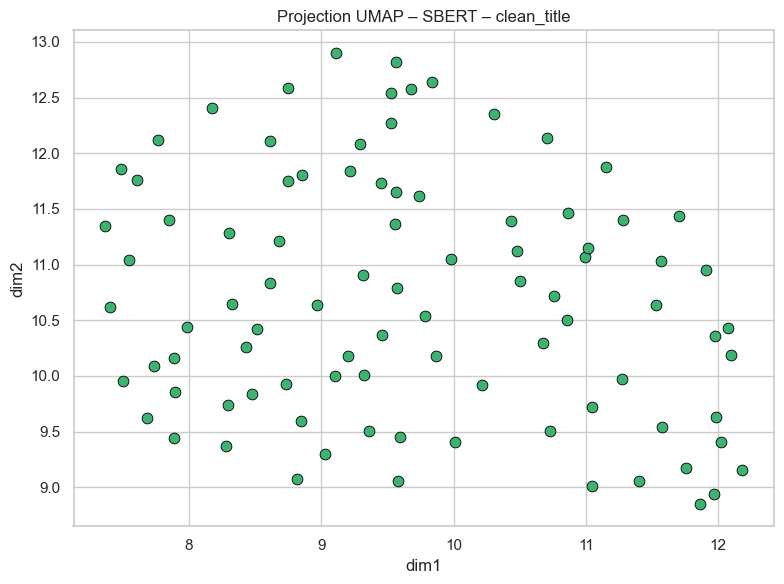

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


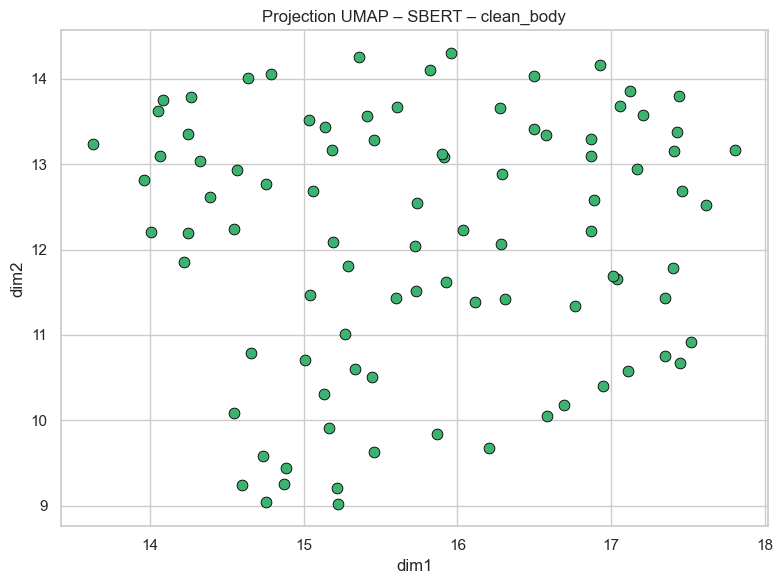

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


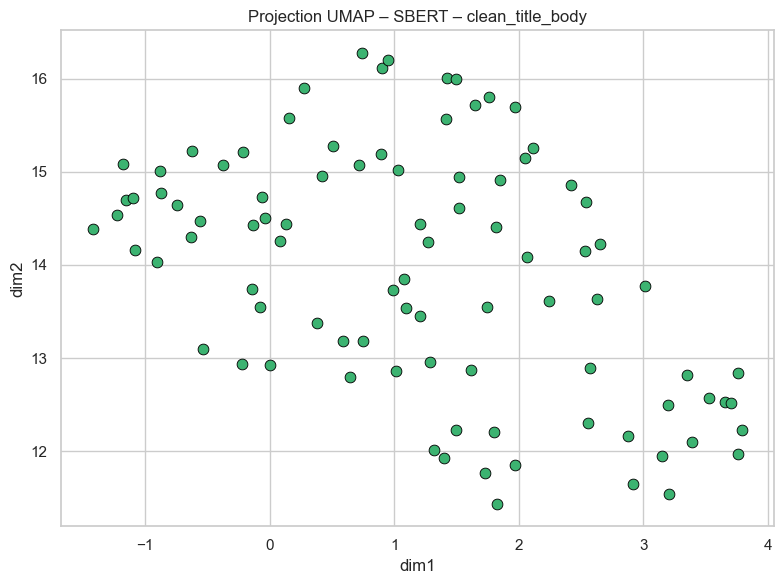

In [21]:

# --- VISUALISATION TSNE
# Conversion pr√©alable
embeddings_title = np.array(embeddings_title)
embeddings_body = np.array(embeddings_body)
embeddings_titlebody = np.array(embeddings_titlebody)

eda.plot_tsne(embeddings_title, label="SBERT ‚Äì title")
eda.plot_tsne(embeddings_body, label="SBERT ‚Äì body")
eda.plot_tsne(embeddings_titlebody, label="SBERT ‚Äì title + body")

# --- VISUALISATION UMAP
# clean_title
eda.plot_umap(embeddings_title, label="SBERT ‚Äì clean_title")
# clean_body
eda.plot_umap(embeddings_body, label="SBERT ‚Äì clean_body")
# clean_title_body
eda.plot_umap(embeddings_titlebody, label="SBERT ‚Äì clean_title_body")


##### 4.1.3.2. METHODE WORD2VEC

In [22]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# --- CREATION DES CORPUS
corpus_title = sample_explo_wo["clean_title"].fillna("").tolist()
corpus_body = sample_explo_wo["clean_body"].fillna("").tolist()
corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()
# --- ENCODAGE WORD2VEC VIA API
# embeddings_title = [get_embedding(text, model="word2vec") for text in tqdm(corpus_title, desc="Word2Vec ‚Äì title")]
# embeddings_body = [get_embedding(text, model="word2vec") for text in tqdm(corpus_body, desc="Word2Vec ‚Äì body")]
# embeddings_titlebody = [get_embedding(text, model="word2vec") for text in tqdm(corpus_titlebody, desc="Word2Vec ‚Äì title+body")]



# eda.plot_umap(embeddings_title, label="Word2Vec ‚Äì clean_title")
# eda.plot_umap(embeddings_body, label="Word2Vec ‚Äì clean_body")
# eda.plot_umap(embeddings_titlebody, label="Word2Vec ‚Äì clean_title_body")


##### 4.1.3.3. METHODE UNIVERSAL SENTENCE ENCODER (USE)

In [23]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)



# --- PREPARATION DES CORPUS
corpus_title = sample_explo_wo["clean_title"].fillna("").tolist()
corpus_body = sample_explo_wo["clean_body"].fillna("").tolist()
corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()

# --- ENCODAGE USE VIA API
# embeddings_title = [get_embedding(text, model="use") for text in tqdm(corpus_title, desc="USE ‚Äì title")]
# embeddings_body = [get_embedding(text, model="use") for text in tqdm(corpus_body, desc="USE ‚Äì body")]
# embeddings_titlebody = [get_embedding(text, model="use") for text in tqdm(corpus_titlebody, desc="USE ‚Äì title+body")]

# --- VISUALISATION UMAP
# eda.plot_umap(embeddings_title, label="USE ‚Äì clean_title")
# eda.plot_umap(embeddings_body, label="USE ‚Äì clean_body")
# eda.plot_umap(embeddings_titlebody, label="USE ‚Äì clean_title_body")



#### **4.1.4. ENCODAGE DES TAGS (MULTI-LABEL BINARIZER)**

**Objectif:**  
Pr√©parer les cibles pour la classification  

Dans le cadre de notre t√¢che de classification multi-label, chaque question peut √™tre associ√©e √† plusieurs tags.  
Il est donc n√©cessaire de transformer la liste de tags de chaque question en un format binaire exploitable par les mod√®les supervis√©s.  
Dans cette sous-section, nous utilisons un `MultiLabelBinarizer` pour encoder les tags sous forme de vecteurs 0/1, o√π chaque colonne repr√©sente un tag unique.  
Ce format permettra d‚Äôentra√Æner des mod√®les capables de pr√©dire plusieurs tags simultan√©ment pour une m√™me question.


# --- ON AFFICHE LES TAGS ENCODES


.net  .net-4.0  64-bit  addsubview  ado.net-entity-data-model  algorithm  \
0      0         0       0           0                          0          1   
1      0         0       0           0                          0          1   
2      0         0       0           0                          0          0   
3      0         0       0           0                          0          0   
4      0         0       0           0                          0          0   
..   ...       ...     ...         ...                        ...        ...   
86     0         0       0           0                          0          0   
87     0         0       0           0                          0          0   
88     0         0       0           0                          0          0   
89     0         0       0           0                          0          0   
90     0         0       0           0                          0          0   

    android  angularjs  anonymous-class  arbitrary-precision  ...  \
0         0          0                0                    0  ...   
1         0          0                0                    0  ...   
2         0          0                1                    0  ...   
3         0          0                0                    0  ...   
4         0          0                0                    0  ...   
..      ...        ...              ...                  ...  ...   
86        0          0                0                    0  ...   
87        0          0                0                    0  ...   
88        0          0                0                    0  ...   
89        0          0                0                    0  ...   
90        0          0                0                    0  ...   

    web-services  webrtc  wget  where-clause  windows  wpf  xcode  xcode5  \
0              0       0     0             0        0    0      0       0   
1              0       0     0             0        0    0      0       0   
2              0       0     0             0        0    0      0       0   
3              0       0     0             0        0    0      0       0   
4              0       0     0             0        0    0      1       0   
..           ...     ...   ...           ...      ...  ...    ...     ...   
86             0       0     0             0        0    0      0       0   
87             0       0     0             0        0    0      0       0   
88             0       0     0             0        0    0      0       0   
89             0       0     0             0        0    0      0       0   
90             0       0     0             0        0    1      0       0   

    xcode6  zeus  
0        0     0  
1        0     0  
2        0     0  
3        0     0  
4        1     0  
..     ...   ...  
86       0     0  
87       0     0  
88       0     0  
89       0     0  
90       0     0  

[91 rows x 327 columns]

# --- ON AFFICHE LA FUSION DES TAGS ENCODES AVEC LE DATAFRAME sample_explo_wo : 


PostId                                              Title  \
0   18908639  Why are Haskell Maps implemented as balanced b...   
1    3735748  Measuring the average thickness of traces in a...   
2    4000062           Can we create an object of an interface?   
3   22787209               How to have clusters of stacked bars   
4   27349612  How Do I add Pins (Annotations) with Xcode 6 (...   
..       ...                                                ...   
86   7062605  Grails get Session and Management in Service c...   
87   1001825  How to identify if a Lucene.Net Index exists i...   
88  20959331                Cursor not showing up in UITextView   
89  11787759             How to properly format currency on ios   
90  14348517  Child elements of scrollviewer preventing scro...   

                                                 Body  Score  ViewCount  \
0   <p>From my limited knowledge of Haskell, it se...     21       2798   
1   <p>Here's the problem: I have a number of bina...     19       6026   
2   <pre class="lang-java prettyprint-override"><c...     33      46647   
3   <p>So here is how my data set looks like :</p>...     90      90737   
4   <p>I'm new to the swift language, and haven't ...     16      29467   
..                                                ...    ...        ...   
86  <p>I have a problem with Grails Session. I was...     17      27483   
87  <p>I am using Lucene.Net for indexing and sear...     21       8442   
88  <p>Can anyone think of a reason that the blink...     77      38471   
89  <p>I'm looking for a way to format a string in...     36      49649   
90  <p>I'm having a problem getting mouse wheel sc...     47      28438   

    AnswerCount         CreationDate  TagCount  \
0             4  2013-09-20 04:06:07         5   
1             7  2010-09-17 13:33:43         5   
2             6  2010-10-22 19:01:14         5   
3            10  2014-04-01 13:22:11         5   
4             2  2014-12-07 22:53:47         5   
..          ...                  ...       ...   
86            4  2011-08-15 07:36:34         5   
87            6  2009-06-16 14:23:10         5   
88           11  2014-01-06 21:10:03         5   
89            8  2012-08-03 00:37:56         5   
90            6  2013-01-15 22:59:29         5   

                                                 Tags  \
0   [algorithm, haskell, hashtable, binary-search-...   
1   [language-agnostic, algorithm, image, image-pr...   
2   [java, oop, interface, instance, anonymous-class]   
3   [python, matplotlib, seaborn, stacked-bar-char...   
4                   [maps, xcode, ios, swift, xcode6]   
..                                                ...   
86  [service, session, grails, nullpointerexceptio...   
87  [indexing, search, lucene.net, full-text-searc...   
88       [iphone, uitextfield, uitextview, ipad, ios]   
89        [iphone, numbers, currency, formatter, ios]   
90  [wpf, listbox, event-handling, mousewheel, scr...   

                                          clean_title  ... web-services  \
0   haskell maps implement balanced binary tree in...  ...            0   
1               measure average thickness trace image  ...            0   
2                             create object interface  ...            0   
3                                   cluster stack bar  ...            0   
4                    add pins annotations xcode swift  ...            0   
..                                                ...  ...          ...   
86             grail session management service class  ...            0   
87             identify lucene net index exist folder  ...            0   
88                             cursor show uitextview  ...            0   
89                        properly format currency io  ...            0   
90  child element scrollviewer prevent scroll mous...  ...            0   

    webrtc  wget  where-clause  windows  wpf  xcode  xcode5  xcode6  zeus  
0        0     0             0       

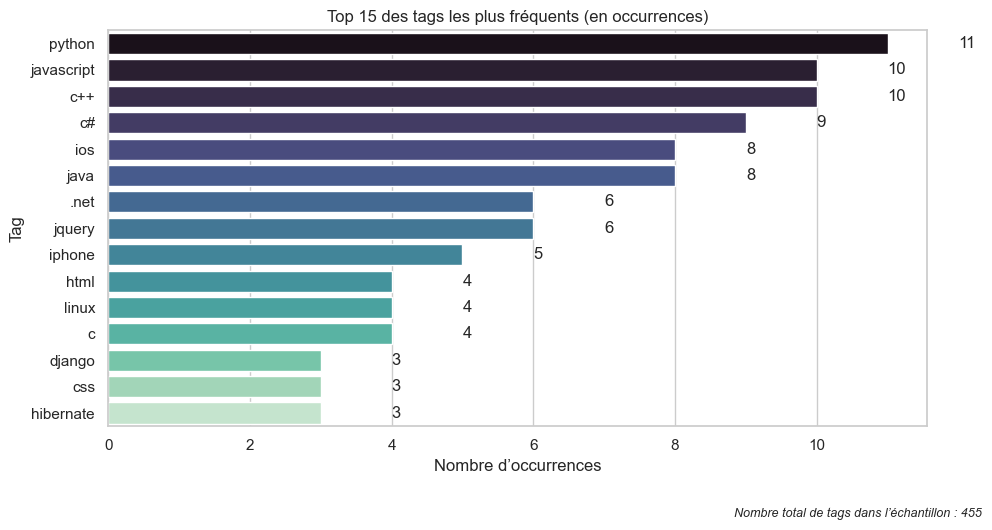

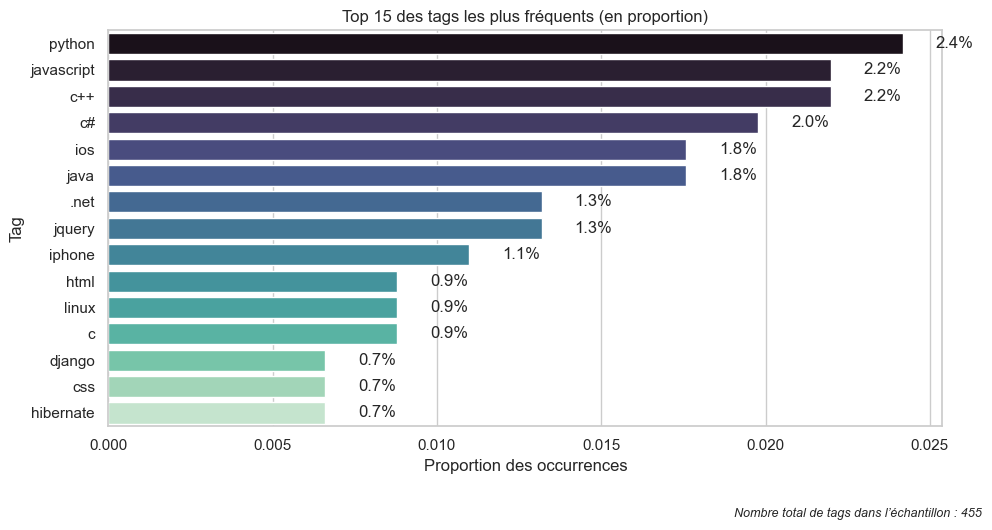

In [24]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)

# ------------------------------------------------------
# --- VERIFICATION ET CONVERSION DES TAGS SI NECESSAIRE
# ------------------------------------------------------
if isinstance(sample_explo_wo["Tags"].iloc[0], str):
    sample_explo_wo["Tags"] = sample_explo_wo["Tags"].apply(ast.literal_eval)
# -------------------------
# --- ENCODAGE MULTI-LABEL
# -------------------------
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(sample_explo_wo["Tags"])
# ---------------------------------
# --- CREATION DU DATAFRAME ENCODE
# ----------------------------------
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)
print("# --- ON AFFICHE LES TAGS ENCODES")
display(tags_df)
# --------------------------------------------
# --- FUSION AVEC LE DATAFRAME sample_explo_wo
# ---------------------------------------------
sample_explo_wo = pd.concat([sample_explo_wo, tags_df], axis=1)
print("# --- ON AFFICHE LA FUSION DES TAGS ENCODES AVEC LE DATAFRAME sample_explo_wo : ")
display(sample_explo_wo)
# ----------------------------
# --- SAUVEGARDE DU BINARIZER
# -----------------------------
# Cr√©e le dossier √† la racine si besoin
os.makedirs("../models", exist_ok=True)
joblib.dump(mlb, "../models/multilabel_binarizer.pkl")

# --- VISUALISATION 
tag_counts = tags_df.sum().sort_values(ascending=False)
tag_freq_df = tag_counts.reset_index()
tag_freq_df.columns = ["Tag", "Count"]
eda.plot_tag_occurrences(tag_freq_df, top_n=15, palette="mako")
eda.plot_tag_distribution(tag_freq_df, top_n=15, palette="mako")


## EXPORT

In [35]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import eda.eda_analysis as eda
importlib.reload(eda)


import os
import joblib
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# ‚öôÔ∏è √âtape 1 : construire le corpus textuel √† partir du texte nettoy√©
corpus = sample_explo_wo[["clean_title", "clean_body"]].apply(lambda x: " ".join(x.dropna().astype(str)), axis=1)

# ‚öôÔ∏è √âtape 2 : vectorisation BoW
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
X_bow = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names_out().tolist()

# ‚öôÔ∏è √âtape 3 : sauvegarde dans 'data/processed'
os.makedirs("data/processed", exist_ok=True)
sample_explo_export = sample_explo_wo[["PostId"]].copy()
sample_explo_export["text_combined"] = corpus
sample_explo_export.to_csv("../data/processed/corpus_for_lda.csv", index=False)

joblib.dump(X_bow, "../data/processed/corpus_for_lda_bow.pkl")
joblib.dump(vocab, "../data/processed/corpus_for_lda_vocab.pkl")


['../data/processed/corpus_for_lda_vocab.pkl']

In [36]:
import pandas as pd

df_corpus = pd.read_csv("../data/processed/corpus_for_lda.csv")
print("üìù corpus_for_lda.csv ‚Üí", df_corpus.shape)
df_corpus.head()


üìù corpus_for_lda.csv ‚Üí (91, 2)


PostId                                      text_combined
0  18908639  haskell maps implement balanced binary tree in...
1   3735748  measure average thickness trace image problem ...
2   4000062  create object interface interface testa string...
3  22787209  cluster stack bar datum set look like pd pd j ...
4  27349612  add pins annotations xcode swift new swift lan...

In [37]:
import joblib

X_bow = joblib.load("../data/processed/corpus_for_lda_bow.pkl")
print("üî¢ Matrice BoW ‚Üí shape:", X_bow.shape)


üî¢ Matrice BoW ‚Üí shape: (91, 499)


In [38]:
vocab = joblib.load("../data/processed/corpus_for_lda_vocab.pkl")
print("üìö Taille du vocabulaire :", len(vocab))
print("üî† 5 premiers mots :", vocab[:5])


üìö Taille du vocabulaire : 499
üî† 5 premiers mots : ['able', 'accept', 'access', 'accomplish', 'act']


## 5. MOD√âLISATION

Apr√®s avoir nettoy√©, explor√© et vectoris√© les donn√©es textuelles, cette section vise √† appliquer des techniques de mod√©lisation pour extraire de l'information ou pr√©dire les tags associ√©s aux questions Stack Overflow.

Nous distinguons deux approches compl√©mentaires :

- **Mod√©lisation non supervis√©e** : pour explorer les th√©matiques latentes du corpus sans utiliser les tags
- **Mod√©lisation supervis√©e** : pour entra√Æner un mod√®le capable de pr√©dire automatiquement les tags √† partir du texte

Chaque approche sera test√©e sur les repr√©sentations vectorielles construites pr√©c√©demment (TF-IDF, embeddings), et √©valu√©e selon des crit√®res adapt√©s √† la t√¢che.

‚ö†Ô∏è Cette section ne sera pas ex√©cut√©e dans ce notebook.  
Elle sert uniquement de rep√®re pour structurer le projet.  
Les mod√©lisations seront r√©alis√©es dans deux notebooks s√©par√©s :
- `2_modelisation_non_supervisee.ipynb`
- `3_modelisation_supervisee.ipynb`



### 5.1. MOD√âLISATION NON SUPERVIS√âE

La mod√©lisation non supervis√©e permet d‚Äôexplorer les structures cach√©es du corpus sans utiliser les tags comme variable cible.  
Dans cette sous-section, nous appliquons des techniques telles que :

- **LDA (Latent Dirichlet Allocation)** pour identifier des th√©matiques latentes dans les questions
- **Clustering (KMeans, DBSCAN, etc.)** pour regrouper les questions selon leur similarit√© s√©mantique

Ces m√©thodes peuvent r√©v√©ler des regroupements th√©matiques, aider √† la navigation dans le corpus, ou enrichir les suggestions de tags.


### 5.2. MOD√âLISATION SUPERVIS√âE

La mod√©lisation supervis√©e vise √† pr√©dire automatiquement les tags associ√©s √† une question √† partir de son texte.  
Il s‚Äôagit d‚Äôun probl√®me de **classification multi-label**, o√π chaque observation (question) peut √™tre associ√©e √† plusieurs classes (tags).

Dans cette sous-section, nous testons plusieurs mod√®les adapt√©s √† cette t√¢che, tels que :

- **Logistic Regression** avec strat√©gie One-vs-Rest
- **Random Forest**, **SVM**, ou **XGBoost**
- **R√©seaux de neurones** (optionnel)

Les performances seront √©valu√©es √† l‚Äôaide de m√©triques sp√©cifiques au multi-label (F1-score, pr√©cision, rappel, etc.).


## ANNEXE 

### A.1. Nomenclature des DataFrames utilis√©s

| Nom du DataFrame       | Description |
|------------------------|-------------|
| `brut_df`              | Donn√©es brutes charg√©es depuis le fichier CSV |
| `sample_df`            | √âchantillon de 100 questions tir√© de `brut_df` |
| `sample_clean`         | Version nettoy√©e de `sample_df` (apr√®s pr√©traitement) |
| `sample_explo`         | Copie de travail pour l‚Äôexploration (√† partir de `sample_clean`) |
| `sample_explo_wo`      | Version de `sample_explo` sans outliers (`wo = without outliers`) |
| `sample_outliers`      | Sous-ensemble de `sample_explo` contenant uniquement les outliers |
| `full_clean`           | Donn√©es compl√®tes nettoy√©es (lors de la mise √† l‚Äô√©chelle) |
| `full_explo`           | Copie de travail pour l‚Äôexploration compl√®te |
| `full_explo_wo`        | Version sans outliers du corpus complet |


### A.2. RAPPELS DES NOTIONS IMPLIQUEES DANS LE FEATURE ENGINEERING EN NLP

Cette annexe vise √† expliciter les concepts math√©matiques et vectoriels sous-jacents aux principales √©tapes de transformation des textes dans le cadre du NLP. Elle s‚Äôadresse √† un lecteur ayant une formation scientifique avanc√©e.



#### A.2.1. Vecteurs creux vs. vecteurs denses

- Un **vecteur creux** (sparse vector) est un vecteur dont la majorit√© des composantes sont nulles.
  - Exemple : `[0, 0, 0.5, 0, 0, 0.3, 0, 0, 0, 0.2]`
  - Typique des repr√©sentations TF-IDF : chaque document n‚Äôutilise qu‚Äôun petit sous-ensemble du vocabulaire.

- Un **vecteur dense** est un vecteur dont la plupart des composantes sont non nulles.
  - Exemple : `[0.12, -0.03, 0.45, 0.08, -0.22, 0.19]`
  - Typique des embeddings ou des vecteurs apr√®s r√©duction de dimension.



#### A.2.2. Variables latentes et espace latent

- Une **variable latente** est une variable non observ√©e directement, mais d√©duite √† partir des donn√©es.
- En NLP, les **axes latents** correspondent √† des th√©matiques ou structures cach√©es dans les textes.
- L‚Äô**espace latent** est un espace vectoriel r√©duit, o√π chaque dimension repr√©sente une composante th√©matique implicite.



#### A.2.3. Base canonique vs. base s√©mantique

- La **base canonique** est form√©e par les mots du vocabulaire : chaque mot est une dimension orthogonale.
- Elle est arbitraire, tr√®s grande, et souvent redondante.
- Une **base s√©mantique** est une base apprise ou extraite (via SVD ou embeddings) o√π chaque dimension refl√®te un th√®me ou une proximit√© de sens.
- Elle est plus compacte, plus informative, mais non orthogonale.



#### A.2.4. D√©composition SVD (Singular Value Decomposition)  

Soit une matrice TF-IDF X de taille (m √ó n), o√π :

- m est le nombre de documents
- n est la taille du vocabulaire (nombre de mots uniques)
- Chaque ligne de X est un vecteur TF-IDF repr√©sentant un document

La d√©composition en valeurs singuli√®res (SVD) permet d‚Äô√©crire :

X = U √ó Œ£ √ó V·µó

avec :

- U ‚àà ‚Ñù^(m √ó r) : matrice des vecteurs propres des documents (orthogonaux)
- Œ£ ‚àà ‚Ñù^(r √ó r) : matrice diagonale contenant les valeurs singuli√®res d√©croissantes
- V ‚àà ‚Ñù^(n √ó r) : matrice des vecteurs propres des mots (orthogonaux)

o√π r est le rang de X (r ‚â§ min(m, n))


**R√©duction de dimension**

En pratique, on ne conserve que les k premi√®res composantes (avec k ‚â™ r), ce qui donne une approximation de rang k :

X ‚âà U_k √ó Œ£_k √ó V_k·µó

avec :

- U_k ‚àà ‚Ñù^(m √ó k) : projection des documents dans un espace latent de dimension k
- Œ£_k ‚àà ‚Ñù^(k √ó k) : valeurs singuli√®res principales
- V_k ‚àà ‚Ñù^(n √ó k) : projection des mots dans le m√™me espace latent


**Interpr√©tation**

- Chaque document est repr√©sent√© par un vecteur dense de dimension k, capturant ses composantes th√©matiques latentes
- Chaque mot est √©galement projet√© dans cet espace, r√©v√©lant ses affinit√©s s√©mantiques
- Les valeurs singuli√®res indiquent l‚Äôimportance relative de chaque axe latent

**Utilit√© en NLP**

- R√©duction de dimension : compresser les vecteurs TF-IDF tr√®s grands et creux
- Suppression du bruit lexical : √©liminer les dimensions peu informatives
- D√©couverte de th√©matiques : chaque axe latent peut √™tre interpr√©t√© comme un th√®me s√©mantique

Cette technique est √† la base de la m√©thode LSA (Latent Semantic Analysis).

#### A.2.5. Embeddings (Word2Vec, FastText, BERT‚Ä¶)

- Les **embeddings** sont des vecteurs denses appris par des mod√®les de langage.
- Ils sont construits pour que les mots ayant des contextes similaires aient des vecteurs proches.
- Contrairement √† TF-IDF, ils capturent :
  - La **s√©mantique** (proximit√© de sens)
  - Le **contexte** (dans les mod√®les comme BERT)
  - Les **relations syntaxiques** et **logiques**

Exemple d‚Äôanalogie vectorielle :  
`king - man + woman ‚âà queen`

Math√©matiquement, les embeddings sont issus d‚Äôune **factorisation implicite** de la matrice de co-occurrence des mots, ou d‚Äôun apprentissage supervis√©/non supervis√© sur des t√¢ches de pr√©diction de contexte.



#### A.2.6. Encodage des tags ‚Äì MultiLabelBinarizer

- Les tags sont des cibles multi-label (un document peut avoir plusieurs √©tiquettes).
- Le **MultiLabelBinarizer** transforme chaque liste de tags en un vecteur binaire.

Exemple :

| Tags | Encodage |
|------|----------|
| ['python', 'django'] | [1, 0, 1, 0, ‚Ä¶] |

Chaque dimension correspond √† un tag unique.  
Ce format est requis pour entra√Æner un mod√®le de classification multi-label.



#### A.2.7. R√©sum√© global du pipeline vectoriel

| √âtape | Entr√©e | Sortie | Objectif |
|-------|--------|--------|----------|
| TF-IDF | Texte brut | Vecteurs creux | Pond√©rer les mots |
| SVD / PCA | TF-IDF | Vecteurs denses r√©duits | Capturer les axes th√©matiques |
| Embeddings | Texte brut | Vecteurs denses s√©mantiques | Capturer le sens |
| MultiLabelBinarizer | Tags | Vecteurs binaires (cibles) | Pr√©parer les cibles |

---


### A.3. FONCTIONNEMENT DE FASTAPI

```text
+-------------------------------+
|        Client (UI,           |
|   script Python, Swagger)    |
+---------------+---------------+
                |
                |  POST /embed/sbert
                |  { "text": "..." }
                v
+---------------+---------------+
|         FastAPI App           |
|     (src/api/main.py)         |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  Route /embed/sbert           |
|  (embed_routes.py)            |
|  - Valide l'entr√©e (pydantic) |
|  - Appelle encode_with_sbert  |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  SBERT Model (sbert_model.py) |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  Embedding vector (list)      |
|  ex: [0.123, -0.456, ...]     |
+---------------+---------------+
                |
                v
+-------------------------------+
|   JSON Response to Client     |
|   { "embedding": [...] }      |
+-------------------------------+
